<hr style="height:5px;border-width:0;color:orange;background-color:orange">
<h1 style="blackground:#FCB700; border:0; border-radius: 10px; color:white; font-size: 32px;"> <center> <b>NUCLIO DIGITAL SCHOOL -</b> MASTER EN DATA SCIENCE </center> </h1>
<h1 style="display: flex; align-items: right;">
    <div align="center"><img src="https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png" alt="Nuclio logo" style="height: 100px; margin-right: 10px; align=right"></div>
</h1>
<h1 style='background:#FCB700; border:0; border-radius: 10px; color:white'>
    <center>Capstone Project  -  Retail</center>
</h1>
<span style="font-size: 16px;">

+ Año: **2024**
+ Autores: **Juan José Guerrero, Adrian Ortega, Ariana Puentes,  Cristina Sánchez**
+ Tutor: **Daniel Pegalajar Luque**

</span>
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


# <h2 style='background:#b1b1b1; border:0; border-radius: 10px; color:black'><center>CONFIGURACIÓN NOTEBOOK</center></h2>

## Importación librerias

In [1]:
#Librerias generales
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import sqrt
import warnings
import holidays
from pylab import rcParams
import pickle

#librerias procesamiento
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import RobustScaler

#librerias modelos
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose import make_reduction,TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter , SlidingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.func_transform import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

#Librerias time series
import pymannkendall as mk
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

##ML
###Bagging
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import plot_tree
###Boosting
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor
##propher
from prophet import Prophet
from prophet.plot import plot, plot_components, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
##ARIMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#librerias optimizacion y validacion cruzada
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold

#librerias metricas y validacion del modelo
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error, root_mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import shap

#Librerias visualización
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from matplotlib import pyplot as plt

## Configuraciones

In [6]:
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = '{:,.4f}'.format

#configuración google drive
# drive.mount('/content/drive', force_remount=True) #descomentar si se trabaja en google

<h1 style='background:#b1b1b1; border:0; border-radius: 10px; color:black'>
    <center>T3. MODELOS DE PREDICCIÓN</center>
</h1>

# <h2 style='background:#4e4e4e; border:0; border-radius: 10px; color:black'><center>OBJETIVOS</center></h2>

En este estudio se ha desarrollado un análisis de series temporales con el objetivo de predecir las ventas. Se han empleado diversas metodologías y modelos de aprendizaje automático para optimizar la predicción de las ventas y entender los patrones temporales presentes en los datos.
La predicción de tendencias es una de las aplicaciones más avanzadas del análisis de datos en supermercados. Mediante el uso de modelos estadísticos y técnicas de Machine Learning, se pueden anticipar cambios en el comportamiento del consumidor, lo que permite adaptar la oferta de productos y las estrategias comerciales con mayor precisión. Identificar tendencias emergentes en el consumo, como el aumento de la demanda de productos orgánicos o sin gluten, brinda una ventaja competitiva al supermercado al permitirle adelantarse a las necesidades del mercado. Además, la capacidad de prever cambios en la demanda ayuda a optimizar el stock y a desarrollar estrategias de marketing más efectivas. Con estos análisis, se pueden detectar oportunidades para lanzar nuevos productos o adaptar las campañas promocionales de manera más efectiva.

# <h2 style='background:#4e4e4e; border:0; border-radius: 10px; color:black'><center>0. ANÁLISIS TEMPORAL DE DATOS</center></h2>


## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.1. CARGA DE DATOS</center></h3>

In [2]:
df = pd.read_pickle ('df_total.pkl')
df_ts = df.groupby("date")["daily_sales"].sum().reset_index()


## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.2. DISTRIBUCION DE LA SERIE</center></h3>

In [8]:
# Agregar columnas de mes y día de la semana
df_ts["Month"] = df_ts["date"].dt.month
df_ts["Weekday"] = df_ts["date"].dt.weekday

# Función adaptada para analizar la distribución de los datos
def data_distribution_graph(df):
    # Histograma de ventas diarias
    fig = px.histogram(df, x='daily_sales', title="Distribución de Ventas Diarias")
    fig.show()

    # Distribución por meses
    fig1 = px.box(df, x='Month', y='daily_sales', title="Distribución de Ventas por Mes")
    fig1.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
                "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
    )
    fig1.show()

    # Distribución por día de la semana
    fig2 = px.box(df, x='Weekday', y='daily_sales', title="Distribución de Ventas por Día de la Semana")
    fig2.update_xaxes(
        tickvals=list(range(7)),
        ticktext=["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
    )
    fig2.show()

# Llamar a la función para generar los gráficos
data_distribution_graph(df_ts)

<b>Histograma de Ventas Diarias:</b>

La distribución de las ventas tiene una ligera asimetría a la derecha, lo que indica que hay días con ventas mucho más altas que la media.
Se observa un pico alrededor de valores medios de ventas, lo que sugiere que la mayoría de los días tienen ventas en un rango estable, con algunas excepciones de días con ventas muy altas.

<b>Boxplot de Ventas por Mes:</b>

Se observan diferencias en la distribución de ventas a lo largo de los meses.
Algunos meses tienen una variabilidad mayor en las ventas (presencia de valores atípicos), lo que podría indicar estacionalidad en las ventas.
Es posible que haya meses con ventas significativamente más altas debido a eventos o promociones.

<b>Boxplot de Ventas por Día de la Semana:</b>

La mediana de ventas es diferente según el día de la semana.
Se observa una mayor dispersión en algunos días, lo que podría indicar que ciertos días tienen más fluctuaciones en la demanda.
Podría haber patrones donde ciertos días de la semana (por ejemplo, fines de semana) tienen mayores ventas en comparación con días laborales.

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.3. AUTOCORRELACION Y AUTOCORRELACION PARCIAL</center></h3>

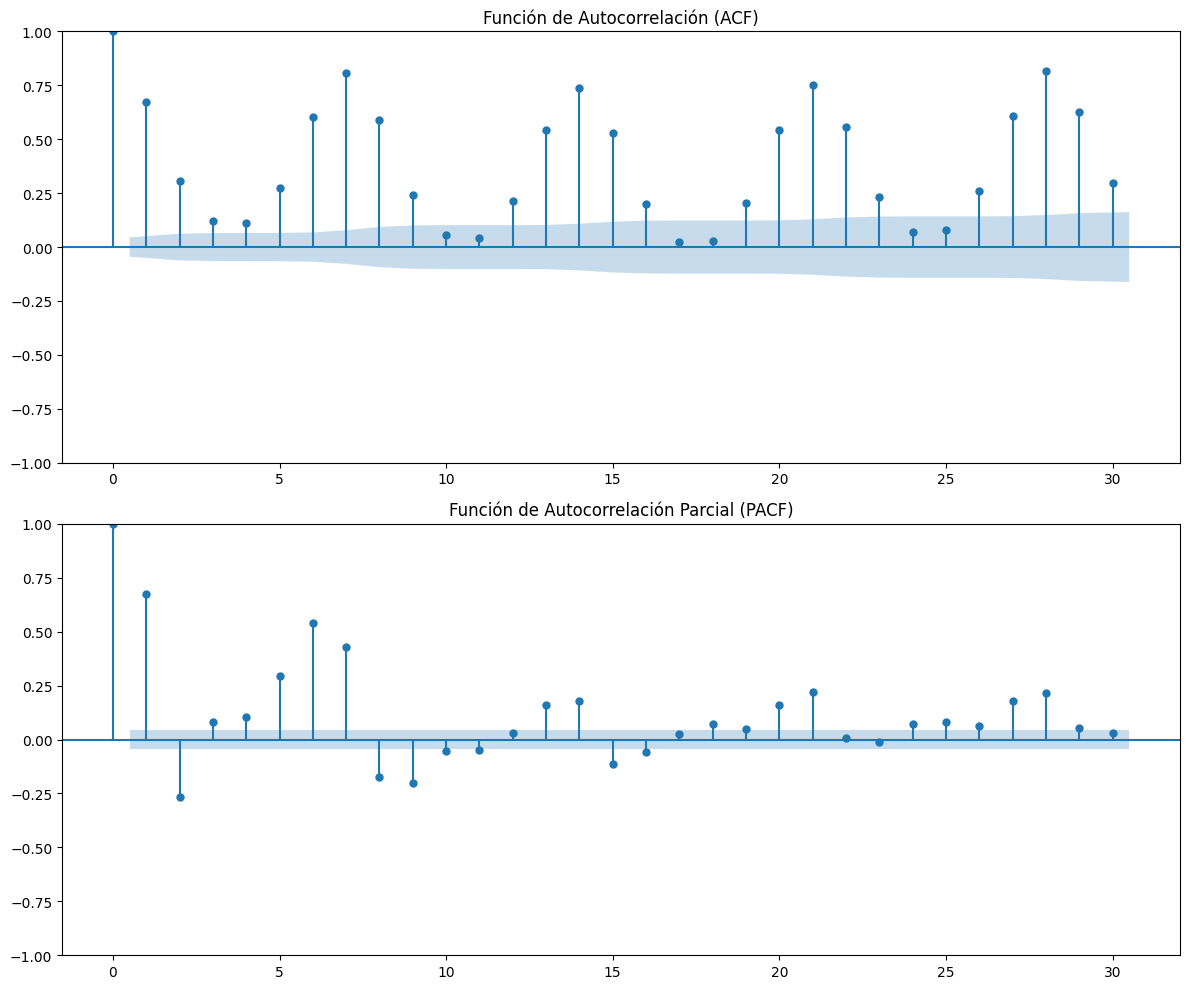

In [9]:
# Crear la figura para ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Autocorrelación (ACF)
plot_acf(df_ts["daily_sales"], lags=30, ax=axes[0])
axes[0].set_title("Función de Autocorrelación (ACF)")

# Autocorrelación Parcial (PACF)
plot_pacf(df_ts["daily_sales"], lags=30, ax=axes[1])
axes[1].set_title("Función de Autocorrelación Parcial (PACF)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

La ACF indica un ciclo semanal en las ventas.
La PACF confirma la importancia del lag 1 y lag 7.

 La serie tiene una estacionalidad clara con periodicidad de 7 días, lo cual es esperable en datos de ventas en retail. Esto implica que los patrones de venta se repiten semanalmente.

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.4. DESCOMPOSICION DE LA SERIE</center></h3>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.4.1 SEMANAL</center></h4>

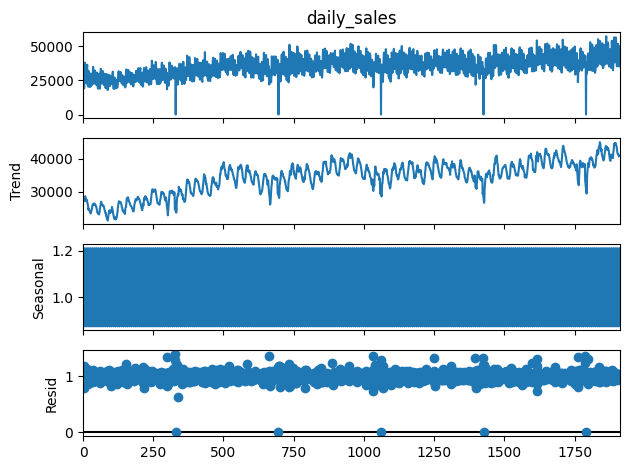

In [10]:
# Realizar la descomposición multiplicativa con período de 7 días.
result_plot = seasonal_decompose(df_ts["daily_sales"], model="multiplicative", period=7).plot()

# Mostrar el resultado
plt.show()

<b>Serie Original</b>

Se observa la fluctuación de las ventas diarias con una clara variabilidad a lo largo del tiempo.

<b>Tendencia</b>

Se aprecia un patrón de crecimiento en la demanda a largo plazo.
La tendencia parece bastante suave, lo que sugiere que los cambios a largo plazo no son bruscos.

<b>Estacionalidad</b>

El patrón estacional se repite cada 7 días, confirmando la presencia de una periodicidad semanal en las ventas.
Las fluctuaciones estacionales son proporcionales a la magnitud de la serie original, lo que valida el uso del modelo multiplicativo.

<b>Residuos</b>

Los residuos parecen aleatorios, lo cual es una buena señal. Sin embargo, si observamos estructuras en ellos, podría indicar que hay más factores no capturados en el modelo (como eventos especiales o promociones).

Estacionalidad Semanal (period=7) ✅
Se observa un patrón repetitivo cada 7 días, lo que indica que las ventas están influenciadas por los días de la semana.
La función de autocorrelación (ACF) mostró picos en los lags 7, 14 y 21, lo que confirma esta periodicidad.
Esto sugiere que las ventas pueden ser mayores en ciertos días (como fines de semana) y menores en otros.

✔ Conclusión: La estacionalidad semanal es clara y debe incluirse en cualquier modelo predictivo.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.4.2 MENSUAL</center></h4>

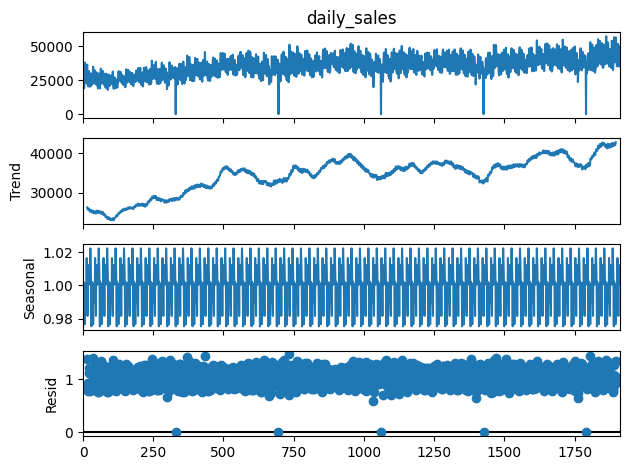

In [11]:
# Realizar la descomposición multiplicativa con período de 30 días.
result_plot = seasonal_decompose(df_ts["daily_sales"], model="multiplicative", period=30).plot()

# Mostrar el resultado
plt.show()

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.4.3 ANUAL</center></h4>

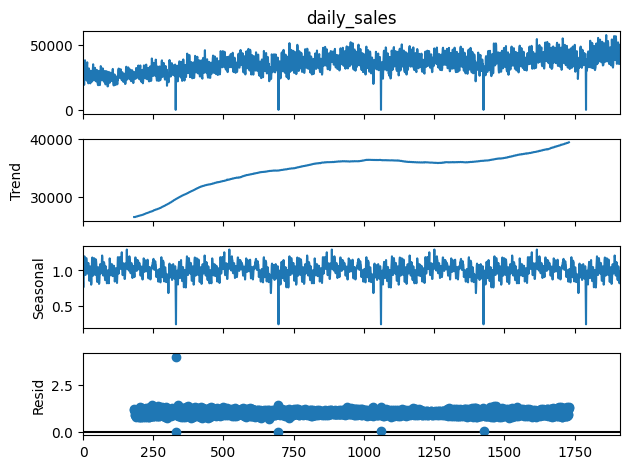

In [12]:
# Realizar la descomposición multiplicativa con período de 365 días.
result_plot = seasonal_decompose(df_ts["daily_sales"], model="multiplicative", period=365).plot()

# Mostrar el resultado
plt.show()

3. Estacionalidad Anual (period=365) ✅
Se observa un patrón repetitivo a lo largo de los años, indicando que las ventas tienen ciclos anuales.
Esto puede estar influenciado por eventos como festividades, Black Friday, descuentos estacionales o tendencias de consumo.
La componente estacional muestra variaciones significativas en ciertos períodos del año, lo que justifica su inclusión en modelos de predicción de largo plazo.

✔ Conclusión: La estacionalidad anual es relevante y debe considerarse en modelos de largo plazo.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.4.4 Elección por fuerza de la estacionalidad</center></h4>

In [13]:
def estacionalidad_fuerza(decomposition):
    """ Calcula la fuerza de la estacionalidad basada en la varianza """
    var_estacional = np.var(decomposition.seasonal.dropna())
    var_residual = np.var(decomposition.resid.dropna())
    return var_estacional / (var_estacional + var_residual)

# Calcular la fuerza de la estacionalidad en cada escala
fuerza_semanal = estacionalidad_fuerza(seasonal_decompose(df_ts['daily_sales'], model='additive', period=7))
fuerza_mensual = estacionalidad_fuerza(seasonal_decompose(df_ts['daily_sales'], model='additive', period=30))
fuerza_anual = estacionalidad_fuerza(seasonal_decompose(df_ts['daily_sales'], model='additive', period=365))

# Mostrar resultados
fuerza_estacionalidad = {
    "Semanal": fuerza_semanal,
    "Mensual": fuerza_mensual,
    "Anual": fuerza_anual
}

fuerza_estacionalidad

{'Semanal': 0.7538673050587454,
 'Mensual': 0.005527891749349202,
 'Anual': 0.4164070217724965}

La estacionalidad semanal es la más fuerte, seguida de la anual, mientras que la mensual tiene una influencia mínima.

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>0.5. ESTACIONARIEDAD</center></h3>

In [14]:
result = adfuller(df_ts['daily_sales'])
print('p-value of the Dickey-Fuller test: %f' % result[1])

p-value of the Dickey-Fuller test: 0.500960


Para que la serie sea estacionaria el p-valor <= 0.05. Como muestra el resultado nuestra serie no es estacionaria.

In [15]:
# Aplicar la primera diferenciación (d=1)
df_ts_diff = df_ts["daily_sales"].diff().dropna()

# Realizar la prueba de Dickey-Fuller después de la primera diferenciación
adf_test_diff1 = adfuller(df_ts_diff)

# Extraer los resultados
adf_statistic_diff1 = adf_test_diff1[0]
p_value_diff1 = adf_test_diff1[1]
critical_values_diff1 = adf_test_diff1[4]

# Mostrar los resultados de la primera diferenciación
adf_result_diff1 = {
    "Estadístico ADF (d=1)": adf_statistic_diff1,
    "Valor p (d=1)": p_value_diff1,
    "Valores Críticos": critical_values_diff1
}

adf_result_diff1

{'Estadístico ADF (d=1)': -23.459578820632622,
 'Valor p (d=1)': 0.0,
 'Valores Críticos': {'1%': -3.4338238606869878,
  '5%': -2.863074513221476,
  '10%': -2.5675869178703854}}

El valor p es 0.0 (< 0.05), lo que significa que podemos rechazar la hipótesis nula y confirmar que la serie no tiene raíz unitaria.

In [16]:
df_ts['daily_sales_diff'] = df_ts['daily_sales'].diff()
df_ts

,date,daily_sales,Month,Weekday,daily_sales_diff
0,2011-01-29,32631,1,5,NaN
1,2011-01-30,31749,1,6,-882.0000
2,2011-01-31,23783,1,0,"-7,966.0000"
3,2011-02-01,25412,2,1,"1,629.0000"
4,2011-02-02,19146,2,2,"-6,266.0000"
...,...,...,...,...,...
1908,2016-04-20,35343,4,2,"-2,227.0000"
1909,2016-04-21,35033,4,3,-310.0000
1910,2016-04-22,40517,4,4,"5,484.0000"
1911,2016-04-23,48962,4,5,"8,445.0000"


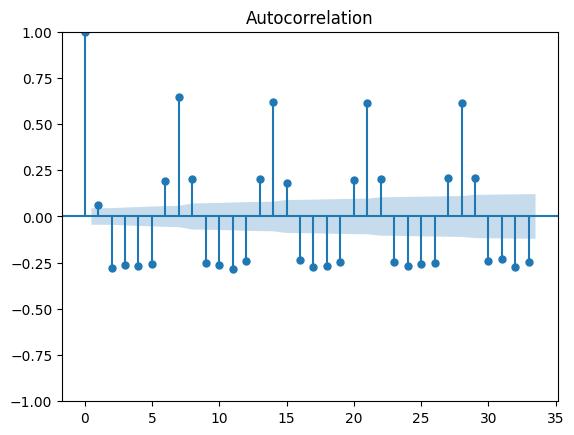

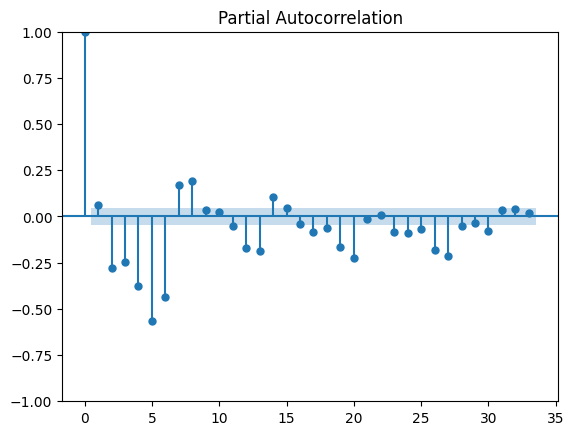

In [17]:
diff_acf = plot_acf(df_ts['daily_sales_diff'].dropna())
diff_pacf = plot_pacf(df_ts['daily_sales_diff'].dropna())

Basándonos en los gráficos de ACF y PACF, podemos proponer los siguientes parámetros para empezar:

p=1 → La PACF tiene un corte claro en lag 1.

d=1 → Aplicamos una diferenciación para hacer la serie estacionaria.

q=1 o q=2 → La ACF muestra un decrecimiento en estos lags.

P=1 → Debido a la estacionalidad semanal.

D=1 → Para capturar la estacionalidad diferenciada.

Q=1 → Siguiendo la estructura de la ACF.

S=7 → Estacionalidad semanal.

SARIMAX(1,1,1)(1,1,1,7)

# <h2 style='background:#4e4e4e; border:0; border-radius: 10px; color:black'><center>1. DESARROLLO DE MODELOS</center></h2>


## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1. SARIMAX</center></h3>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.1 PROCESAMIENTO DE DATOS</center></h4>

In [18]:
df_sarimax = df_ts.copy()
# Asegurar que la columna date sea índice
df_sarimax = df_sarimax[['date','daily_sales']]
df_sarimax = df_sarimax.set_index("date")

# Definir el porcentaje de datos para el conjunto de prueba (20% del total)
test_size = 28

# Dividir los datos en train y test
train_sarima = df_sarimax.iloc[:-test_size]
test_sarima = df_sarimax.iloc[-test_size:]

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.2 DESARROLLO DE PRIMER MODELO</center></h4>

In [19]:
# Estima el modelo
model_sarimax = SARIMAX(train_sarima['daily_sales'],
                    order=(1,1,1),
                    seasonal_order=(1,1,1,7)
                    )
result_sarimax = model_sarimax.fit()
result_sarimax.summary()

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       daily_sales   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17911.203
Date:                           Wed, 19 Mar 2025   AIC                          35832.407
Time:                                   16:23:19   BIC                          35860.094
Sample:                               01-29-2011   HQIC                         35842.605
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5131      0.010     51.088      0.000       0.493       0.533
ma.L1         -0.9970      0.001   -971.864      0.000      -0.999      -0.995
ar.S.L7        0.2261      0.027      8.524      0.000       0.174       0.278
ma.S.L7       -0.9982      0.010   -101.055      0.000      -1.018      -0.979
sigma2      1.232e+07    1.1e-09   1.12e+16      0.000    1.23e+07    1.23e+07
===================================================================================
Ljung-Box (L1) (Q):                  20.53   Jarque-Bera (JB):             64447.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.71e+30. Standard errors may be unstable.
"""

Los términos AR(1) y MA(1) son significativos (p-valor < 0.05), lo que indica que hay una fuerte dependencia entre las ventas actuales y las pasadas.

Los términos estacionales (AR y MA en retrasos de 7 días) son altamente significativos, lo que confirma que hay una estacionalidad semanal en las ventas.

La varianza del error (𝜎2) es bastante alta, lo que sugiere que hay una gran variabilidad en las predicciones.

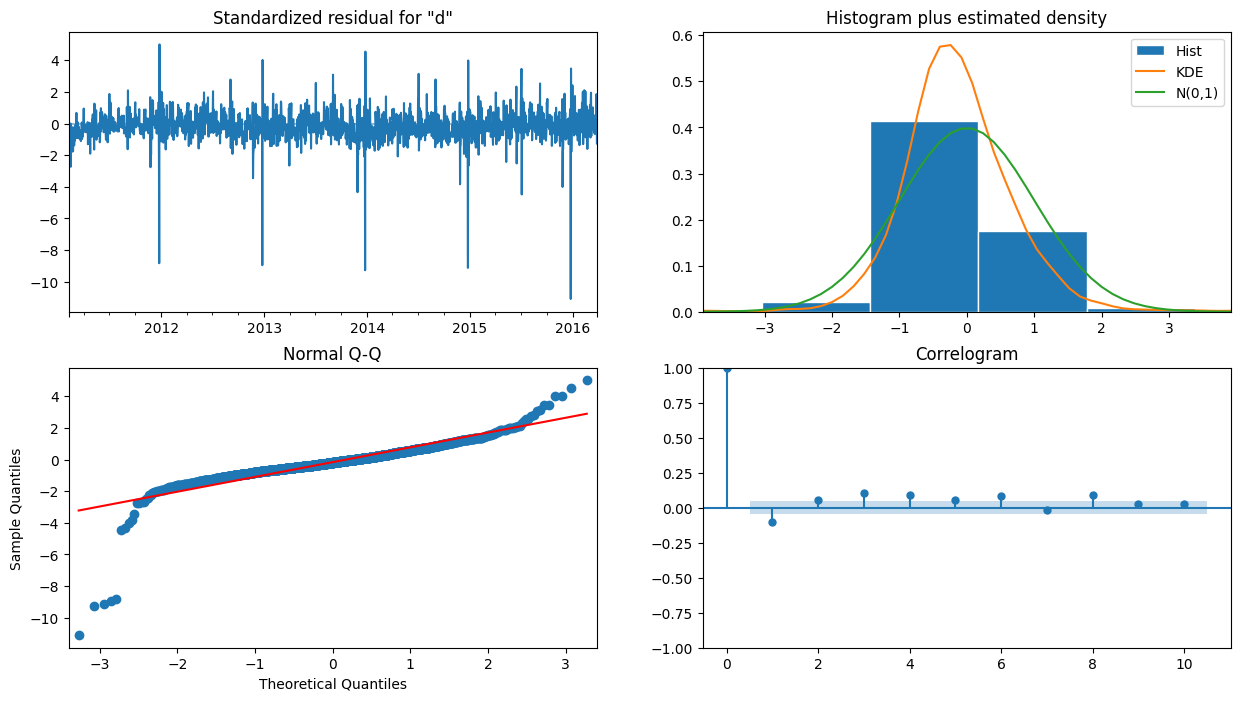

In [20]:
rcParams['figure.figsize'] = 15, 8

result_sarimax.plot_diagnostics()
plt.show()

<b>Residuals vs. Time Plot:</b>

Los residuos parecen estar distribuidos alrededor de cero, pero hay algunos picos que pueden indicar puntos atípicos.

<b>Histograma de los residuos:</b>

La distribución no es perfectamente normal, lo que puede afectar la precisión de las predicciones.

<b>Q-Q Plot (Quantile-Quantile Plot):</b>

Muestra que los residuos no siguen completamente una distribución normal, especialmente en los extremos.

<b>Correlograma de los residuos (ACF de los residuos):</b>

No hay autocorrelación significativa en la mayoría de los lags, lo cual es un buen indicador de un modelo bien ajustado.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.3 DESARROLLO DE MODELO CON TRANSFORMACIÓN LOGARÍTMICA</center></h4>

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



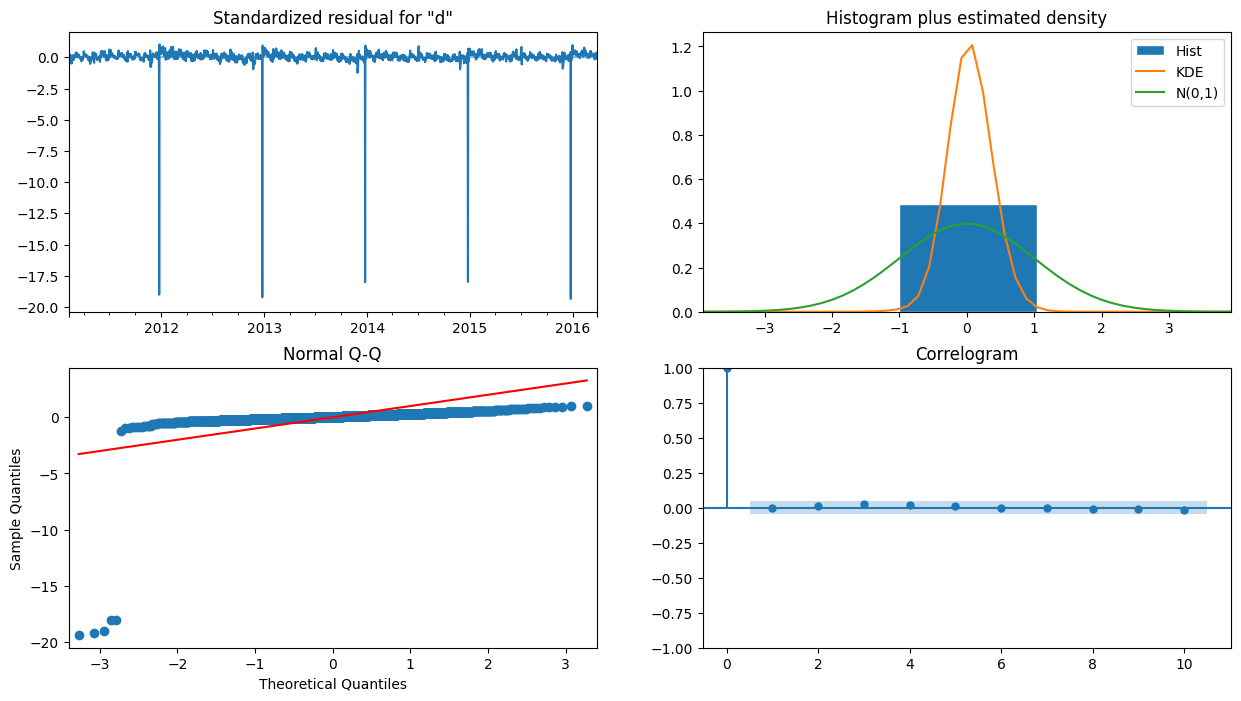

In [21]:
# Aplicar transformación logarítmica para estabilizar la varianza
df_sarimax['daily_sales_log'] = np.log1p(df_sarimax['daily_sales'])  # log(1 + x) para evitar log(0)

# Dividir en train y test con la serie transformada
train_sarima_log = df_sarimax.iloc[:-test_size]['daily_sales_log']
test_sarima_log = df_sarimax.iloc[-test_size:]['daily_sales_log']

# Ajustar modelo SARIMAX con los datos transformados
model_sarimax_log = SARIMAX(train_sarima_log,
                            order=(1,1,1),
                            seasonal_order=(1,1,1,7))

result_sarimax_log = model_sarimax_log.fit()

# Diagnóstico del nuevo modelo
result_sarimax_log.plot_diagnostics(figsize=(15,8))
plt.show()

Mejoras observadas:

✔️ Los residuos están más centrados alrededor de cero, lo que indica una mejor normalidad.

✔️ La varianza de los residuos parece más estable, lo que sugiere que la transformación ha ayudado a estabilizar la serie.

✔️ El histograma de residuos es más cercano a una distribución normal, mejorando la calidad del modelo.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.4 PREDICCIÓN</center></h4>

In [22]:
# Hacer predicciones en el conjunto de prueba
sarima_final_forecast = result_sarimax_log.predict(start=len(train_sarima_log),
                                                end=len(df_sarimax)-1,
                                                dynamic=False)

# Reconvertir las predicciones aplicando la exponencial inversa (para deshacer log(1+x))
sarima_final_forecast_original = np.expm1(sarima_final_forecast)

# Reconvertir los valores reales de test para comparación
test_sarima_original = np.expm1(test_sarima_log)

# Crear la figura
fig = go.Figure()

# Agregar la serie de ventas reales
fig.add_trace(go.Scatter(x=df_sarimax.index, y=df_sarimax['daily_sales'],
                        mode='lines', name='Ventas Reales', line=dict(color='blue')))

# Agregar la serie de predicciones
fig.add_trace(go.Scatter(x=test_sarima_original.index, y=sarima_final_forecast_original,
                        mode='lines', name='Predicción SARIMA (Final)', line=dict(color='red')))

# Agregar línea vertical para indicar el inicio del conjunto de prueba
fig.add_vline(x=df_sarimax.index[-test_size], line=dict(color='black', dash='dash'), name="Inicio de Predicción")

# Configurar el diseño del gráfico
fig.update_layout(title="Predicción de Ventas en el Conjunto de Test con SARIMA Final",
                xaxis_title="Fecha",
                yaxis_title="Ventas",
                legend_title="Leyenda",
                template="plotly_white")

# Mostrar el gráfico interactivo
fig.show()

# Guardar predicciones en un DataFrame
df_predictions_test = pd.DataFrame({
    'date': test_sarima_original.index,
    'actual_sales': test_sarima_original.values,
    'predicted_sales': sarima_final_forecast_original.values
})

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.4 EVALUACIÓN</center></h4>

In [23]:
# Calcular métricas de evaluación para el modelo SARIMA final

# MAE (Mean Absolute Error)
mae_final = mean_absolute_error(test_sarima_original, sarima_final_forecast_original)

# RMSE (Root Mean Squared Error)
rmse_final = mean_squared_error(test_sarima_original, sarima_final_forecast_original, squared=False)

# MAPE (Mean Absolute Percentage Error)
mape_final = np.mean(np.abs((test_sarima_original - sarima_final_forecast_original) / test_sarima_original)) * 100

# Crear un DataFrame con las métricas
df_evaluation = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "MAPE"],
    "Valor": [mae_final, rmse_final, mape_final]
})

df_evaluation

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



,Métrica,Valor
0,MAE,"2,773.9337"
1,RMSE,"3,463.2741"
2,MAPE,6.2707


Conclusión:

✔️ El modelo SARIMA tiene un buen rendimiento, con un error relativamente bajo en comparación con las ventas totales.

✔️ El MAPE es aceptable en problemas de predicción de ventas, indicando que el modelo predice con buena precisión.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.1.5 PREDICCIONES A FUTURO</center></h4>

In [24]:
# Definir el rango de fechas para la predicción futura (28 días después del test)
future_dates = pd.date_range(start=df_sarimax.index[-1] + pd.Timedelta(days=1), periods=28, freq='D')

# Hacer predicciones a futuro usando el modelo SARIMA final
sarima_future_forecast = result_sarimax_log.predict(start=len(df_sarimax),
                                                    end=len(df_sarimax) + 27,
                                                    dynamic=False)

# Reconvertir las predicciones aplicando la exponencial inversa (para deshacer log(1+x))
sarima_future_forecast_original = np.expm1(sarima_future_forecast)

# Crear un DataFrame con las predicciones futuras
df_predictions_future = pd.DataFrame({
    'date': future_dates,
    'predicted_sales': sarima_future_forecast_original.values
})

# Crear la figura
fig = go.Figure()

# Agregar la serie de ventas históricas
fig.add_trace(go.Scatter(x=df_sarimax.index, y=df_sarimax['daily_sales'],
                        mode='lines', name='Ventas Reales', line=dict(color='blue')))

# Agregar la serie de predicciones futuras
fig.add_trace(go.Scatter(x=df_predictions_future['date'], y=df_predictions_future['predicted_sales'],
                        mode='lines', name='Predicción SARIMA (Futuro)',
                        line=dict(color='green', dash='dash')))

# Agregar la serie de predicciones
fig.add_trace(go.Scatter(x=test_sarima_original.index, y=sarima_final_forecast_original,
                        mode='lines', name='Predicción SARIMA (Final)', line=dict(color='red')))

# Agregar línea vertical para indicar el inicio de la predicción futura
fig.add_vline(x=df_sarimax.index[-1], line=dict(color='black', dash='dash'), name="Inicio de Predicción")

# Configurar el diseño del gráfico
fig.update_layout(title="Predicción de Ventas para los Próximos 28 Días con SARIMA",
                xaxis_title="Fecha",
                yaxis_title="Ventas",
                legend_title="Leyenda",
                template="plotly_white")

# Mostrar el gráfico interactivo
fig.show()

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.2. AUTOARIMA </center></h3>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.2.1 PROCESAMIENTO DE DATOS</center></h4>

In [25]:
df_autoarima = df_ts.copy()
# Asegurar que la columna date sea índice
df_autoarima = df_autoarima[['date','daily_sales']]
df_autoarima = df_autoarima.set_index("date")

# Definir el porcentaje de datos para el conjunto de prueba (20% del total)
test_size = 28

# Dividir los datos en train y test
train_autoarima = df_autoarima.iloc[:-test_size]
test_autoarima = df_autoarima.iloc[-test_size:]

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.2.2 DESARROLLO DE MODELO</center></h4>

In [26]:
# Ajustar AutoARIMA con los datos de entrenamiento
modelo_autoarima = auto_arima(train_autoarima,
                            seasonal=True,
                            m=7,  # Estacionalidad semanal
                            trace=True,
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38074.808, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=36873.005, Time=1.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=37332.679, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38072.812, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=38071.034, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=36609.813, Time=3.34 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=36518.046, Time=5.18 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=36739.567, Time=2.74 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=36260.036, Time=5.25 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=36548.588, Time=4.99 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=4.72 sec
 ARIMA(2,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.85 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=i

c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning:

Error fitting  ARIMA(1,1,0)(2,0,2)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "c:\Users\Administrador\.conda\

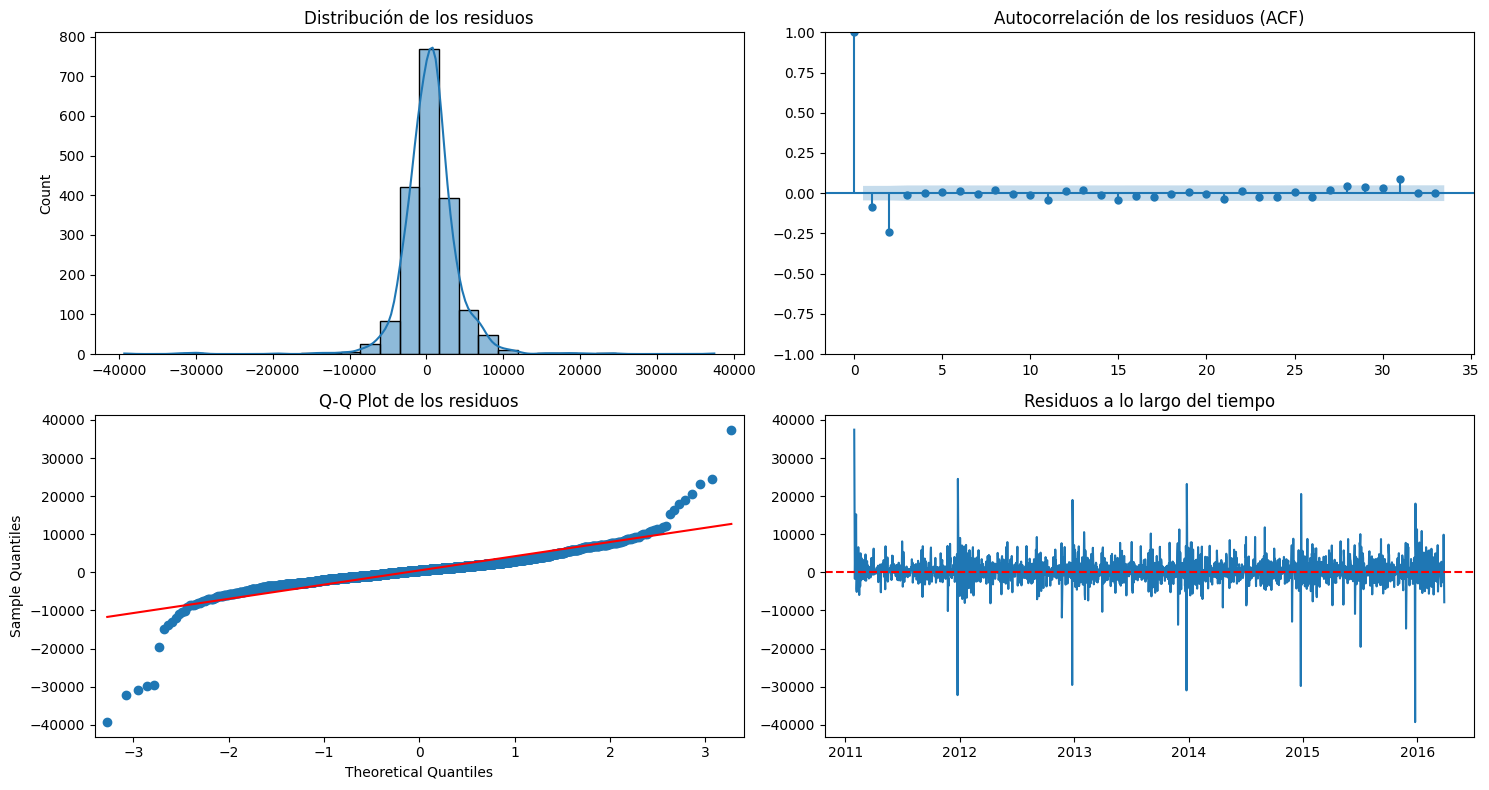

In [27]:
# Obtener residuos del modelo AutoARIMA
residuales = modelo_autoarima.resid()

# Configurar figura
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# 1. Histograma de los residuos
sns.histplot(residuales, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución de los residuos")

# 2. ACF de los residuos
sm.graphics.tsa.plot_acf(residuales, ax=axes[0, 1])
axes[0, 1].set_title("Autocorrelación de los residuos (ACF)")

# 3. Q-Q Plot para ver normalidad
sm.qqplot(residuales, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot de los residuos")

# 4. Gráfico de residuos a lo largo del tiempo
axes[1, 1].plot(residuales)
axes[1, 1].axhline(0, linestyle='dashed', color='red')
axes[1, 1].set_title("Residuos a lo largo del tiempo")

# Mostrar gráficos
plt.tight_layout()
plt.show()

Parece más estable y con menos valores atípicos, lo que sugiere que captura la tendencia general de la serie mejor. Aunque el modelo SARIMAX puede estar capturando mejor la estacionalidad.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.2.3 PREDICCIÓN</center></h4>

In [28]:
# Generar predicciones para el período de prueba (28 días)
predicciones = modelo_autoarima.predict(n_periods=len(test_autoarima))
predicciones = np.array(predicciones).flatten()
# Asegurar que train_autoarima y test_autoarima sean Series y convertirlos en listas
train_autoarima_series = train_autoarima["daily_sales"] if isinstance(train_autoarima, pd.DataFrame) else train_autoarima
test_autoarima_series = test_autoarima["daily_sales"] if isinstance(test_autoarima, pd.DataFrame) else test_autoarima

# Convertir a listas
train_autoarima_list = train_autoarima_series.tolist()
test_autoarima_list = test_autoarima_series.tolist()

# Crear un DataFrame combinado con los datos de entrenamiento y prueba
df_plot = pd.DataFrame({
    "Fecha": train_autoarima_series.index.tolist() + test_autoarima_series.index.tolist(),
    "Ventas": train_autoarima_list + test_autoarima_list,
    "Tipo": ["Entrenamiento"] * len(train_autoarima_list) + ["Test"] * len(test_autoarima_list)
})

# Agregar las predicciones al DataFrame
df_predicciones = pd.DataFrame({
    "Fecha": test_autoarima_series.index,
    "Ventas": predicciones,
    "Tipo": ["Predicción AutoARIMA"] * len(predicciones)
})

# Concatenar los datos de entrenamiento, test y predicciones
df_plot = pd.concat([df_plot, df_predicciones])

# Crear el gráfico interactivo con Plotly Express
fig = px.line(df_plot, x="Fecha", y="Ventas", color="Tipo",
            title="Predicción de Ventas con AutoARIMA")

# Mostrar el gráfico interactivo
fig.show()

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.2.4 EVALUACIÓN</center></h4>

In [29]:
# Convertir a Series asegurando que los datos sean 1D
test_autoarima_series = pd.Series(test_autoarima.values.ravel(), index=test_autoarima.index)
predicciones_series = pd.Series(predicciones.ravel(), index=test_autoarima.index)

# Calcular métricas de evaluación
mae = mean_absolute_error(test_autoarima_series, predicciones_series)
rmse = np.sqrt(mean_squared_error(test_autoarima_series, predicciones_series))
mape = np.mean(np.abs((test_autoarima_series - predicciones_series) / test_autoarima_series)) * 100

# Crear DataFrame con las métricas
df_metricas = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "MAPE"],
    "Valor": [mae, rmse, mape]
})
df_metricas

,Métrica,Valor
0,MAE,"8,582.8394"
1,RMSE,"9,400.4989"
2,MAPE,19.9633


Vemos que es mucho peor por lo que lo descartamos el Autoarima.

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3. PROPHET</center></h3>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3.1 PROCESAMIENTO DE DATOS</center></h4>

In [30]:
df_prophet = df_ts.copy()

# Definir el número de días para el conjunto de prueba
test_days = 28

# Separar los datos en entrenamiento y prueba
train = df_prophet[:-test_days]
test = df_prophet[-test_days:]

# Mantener solo las columnas necesarias en train y test
train_prophet = train[["date", "daily_sales"]].rename(columns={"date": "ds", "daily_sales": "y"})
test_prophet = test[["date", "daily_sales"]].rename(columns={"date": "ds", "daily_sales": "y"})

special_events = pd.DataFrame({
    "ds": pd.to_datetime([
        # Super Bowl (primer domingo de febrero)
        "2011-02-06", "2012-02-05", "2013-02-03", "2014-02-02", "2015-02-01", "2016-02-07",
        # Ramadan starts (aproximado, cambia según calendario lunar)
        "2011-08-01", "2012-07-20", "2013-07-09", "2014-06-28", "2015-06-18", "2016-06-06",
        # Thanksgiving (cuarto jueves de noviembre)
        "2011-11-24", "2012-11-22", "2013-11-28", "2014-11-27", "2015-11-26", "2016-11-24",
        # New Year (1 de enero)
        "2011-01-01", "2012-01-01", "2013-01-01", "2014-01-01", "2015-01-01", "2016-01-01",
        # Easter (Domingo de Pascua, variable)
        "2011-04-24", "2012-04-08", "2013-03-31", "2014-04-20", "2015-04-05", "2016-03-27"
    ]),
    "holiday": [
        "SuperBowl", "SuperBowl", "SuperBowl", "SuperBowl", "SuperBowl", "SuperBowl",
        "Ramadan", "Ramadan", "Ramadan", "Ramadan", "Ramadan", "Ramadan",
        "Thanksgiving", "Thanksgiving", "Thanksgiving", "Thanksgiving", "Thanksgiving", "Thanksgiving",
        "NewYear", "NewYear", "NewYear", "NewYear", "NewYear", "NewYear",
        "Easter", "Easter", "Easter", "Easter", "Easter", "Easter"
    ]
})

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3.2 DESARROLLO DE MODELO</center></h4>

In [31]:
# Inicializar Prophet con la configuración deseada
model_pr_events = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative",  # Modo multiplicativo para mejor ajuste
    holidays=special_events  # Añadir eventos personalizados (SuperBowl, Ramadan, etc.)
)

# Incluir los festivos oficiales de EE.UU.
model_pr_events.add_country_holidays(country_name="US")

# Entrenar el modelo
model_pr_events.fit(train_prophet)

16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing


### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3.3 PREDICCIÓN</center></h4>

In [32]:
# Crear un dataframe con las fechas del conjunto de prueba
future_test = test_prophet[["ds"]].copy()

# Generar predicciones para el conjunto de prueba
forecast_test = model_pr_events.predict(future_test)

# Mostrar las primeras filas de las predicciones
forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-03-28,"39,504.0476","35,996.2016","43,160.7748"
1,2016-03-29,"36,990.3592","33,301.6329","40,512.9659"
2,2016-03-30,"36,626.6057","32,815.2997","40,110.1922"
3,2016-03-31,"37,028.5710","33,719.3292","40,705.9595"
4,2016-04-01,"41,551.9666","37,796.3458","45,104.8799"


In [33]:
# Unir predicciones con los valores reales
results = test_prophet.copy()
results["yhat"] = forecast_test["yhat"].values
results["yhat_lower"] = forecast_test["yhat_lower"].values
results["yhat_upper"] = forecast_test["yhat_upper"].values

# Crear la figura con Plotly
fig = go.Figure()
# Agregar el intervalo de confianza (banda roja)
fig.add_trace(go.Scatter(
    x=results["ds"].tolist() + results["ds"].tolist()[::-1],
    y=results["yhat_upper"].tolist() + results["yhat_lower"].tolist()[::-1],
    fill="toself",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0)"),
    name="Intervalo de confianza (80%)"
))
# Agregar las predicciones de Prophet (línea roja)
fig.add_trace(go.Scatter(
    x=results["ds"],
    y=results["yhat"],
    mode="lines",
    name="Predicciones Prophet",
    line=dict(color="red")
))
# Agregar las ventas reales (línea negra discontinua)
fig.add_trace(go.Scatter(
    x=results["ds"],
    y=results["y"],
    mode="lines",
    name="Ventas reales",
    line=dict(color="black", dash="dash")
))
# Personalizar diseño
fig.update_layout(
    title="Predicciones de Prophet vs. Ventas Reales",
    xaxis_title="Fecha",
    yaxis_title="Ventas diarias",
    template="plotly_white"
)
# Mostrar la gráfica interactiva
fig.show()


### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3.4 EVALUACIÓN</center></h4>

In [34]:
# Calcular métricas de error
# Calcular métricas de error
mae = mean_absolute_error(results["y"], results["yhat"])
rmse = np.sqrt(mean_squared_error(results["y"], results["yhat"]))
mape = mean_absolute_percentage_error(results["y"], results["yhat"])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 2222.23
RMSE: 2731.24
MAPE: 0.05%


El modelo es bastante bueno para captar la tendencia y estacionalidad.

Sin embargo, no predice con precisión los picos de ventas más altos.

El MAE y RMSE indican que hay margen de mejora, pero en términos relativos (MAPE) el error es bajo.

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.3.5 PREDICCIONES A FUTURO</center></h4>

In [35]:
# Obtener la última fecha en el conjunto de prueba
last_test_date = test_prophet["ds"].max()

# Crear un nuevo dataframe con 28 días después del test, asegurando continuidad
future_dates = pd.date_range(start=last_test_date, periods=29, freq="D")  # 29 en vez de 28 para unir con test
future_df = pd.DataFrame({"ds": future_dates})

# Hacer la predicción para el test + 28 días futuros
forecast_future = model_pr_events.predict(future_df)

# Concatenar las predicciones del test y la predicción futura en un solo DataFrame
full_forecast = pd.concat([results, forecast_future], ignore_index=True)

# Crear la figura con Plotly
fig = go.Figure()

# Agregar los datos de TRAIN en ROJO (línea sólida)
fig.add_trace(go.Scatter(
    x=train_prophet["ds"],
    y=train_prophet["y"],
    mode="lines",
    name="Datos Reales (Train)",
    line=dict(color="red")
))
# Agregar el intervalo de confianza en el TEST (banda roja)
fig.add_trace(go.Scatter(
    x=results["ds"].tolist() + results["ds"].tolist()[::-1],
    y=results["yhat_upper"].tolist() + results["yhat_lower"].tolist()[::-1],
    fill="toself",
    fillcolor="rgba(255, 0, 0, 0.2)",
    line=dict(color="rgba(255, 0, 0, 0)"),
    name="Intervalo de confianza (Test)"
))
# Agregar las predicciones del TEST en ROJO
fig.add_trace(go.Scatter(
    x=results["ds"],
    y=results["yhat"],
    mode="lines",
    name="Predicciones Prophet (Test)",
    line=dict(color="red", dash="dot")
))
# Agregar las ventas reales del TEST (línea negra discontinua)
fig.add_trace(go.Scatter(
    x=results["ds"],
    y=results["y"],
    mode="lines",
    name="Ventas reales (Test)",
    line=dict(color="black", dash="dash")
))
# Agregar el intervalo de confianza en la predicción futura (banda azul)
fig.add_trace(go.Scatter(
    x=forecast_future["ds"].tolist() + forecast_future["ds"].tolist()[::-1],
    y=forecast_future["yhat_upper"].tolist() + forecast_future["yhat_lower"].tolist()[::-1],
    fill="toself",
    fillcolor="rgba(0, 0, 255, 0.2)",
    line=dict(color="rgba(0, 0, 255, 0)"),
    name="Intervalo de confianza (Futuro)"
))
# Agregar las predicciones futuras en AZUL
fig.add_trace(go.Scatter(
    x=forecast_future["ds"],
    y=forecast_future["yhat"],
    mode="lines",
    name="Predicciones Prophet (Futuro)",
    line=dict(color="blue")
))
# Personalizar diseño
fig.update_layout(
    title="Predicciones de Prophet",
    xaxis_title="Fecha",
    yaxis_title="Ventas diarias",
    template="plotly_white"
)
# Mostrar la gráfica interactiva
fig.show()

El modelo con eventos captura mejor los picos de ventas en fechas clave.

La reducción del MAE y RMSE indica que las predicciones son más precisas cuando se consideran los eventos.

MAPE sigue siendo muy bajo, lo que significa que los errores siguen siendo pequeños en relación con el volumen total de ventas.

## <h3 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.4. MACHINE LEARNING</center></h3>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.4.1 FUNCION DE DESARROLLO DE MODELOS ML</center></h4>

In [36]:
def train_evaluate_models(df, group, type):
    df_prueba = df.groupby('date').agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
}).reset_index().copy()
    df_prueba.loc[df_prueba['daily_sales'] == 0, 'daily_sales'] += 1
    df_prueba.set_index("date", inplace=True)

    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    test_days = 28
    df_prueba.sort_index(inplace=True)
    df_prueba.dropna(inplace=True)
    train_X = df_prueba.iloc[:-test_days][columns_X]
    train_y = df_prueba.iloc[:-test_days][columns_y]
    test_X = df_prueba.iloc[-test_days:][columns_X]
    test_y = df_prueba.iloc[-test_days:][columns_y]

    train_y = train_y.asfreq('D')  # Forzar frecuencia diaria
    test_y = test_y.asfreq('D')  # Aplicar también al conjunto de prueba

    models = {
        'XGBoost': XGBRegressor(random_state=42),
        'CatBoost': CatBoostRegressor(random_state=42),
        'LightGBM': LGBMRegressor(random_state=42)
    }
    metrics = {}
    predictions = {}
    predictions_future = {}
    for name, model in models.items():
        validation_size = len(test_y)
        fh = ForecastingHorizon(np.arange(1, 29), is_relative=True)
        forecaster = TransformedTargetForecaster(
            [
                ("deseasonalize_28", Deseasonalizer(model="multiplicative", sp=28)),  # Quita estacionalidad mensual (28 días)
                ("LogTransformer", LogTransformer()),  # Aplica transformación logarítmica
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),  # Elimina tendencia lineal
                ("forecast", make_reduction(model, window_length=28, strategy="recursive", scitype='tabular-regressor')),  # Usa XGBoost con ventana de 28 días
            ]
        )
        # Ajustar Expanding Window Cross-Validation
        cv = SlidingWindowSplitter(
            window_length=28*6,  # 6 meses de historial en cada fold
            fh=fh,  # Predicción de 28 días
            step_length=validation_size  # Se mueve 1 mes en cada iteración
        )
        # 🔹 Ajustar la grilla de hiperparámetros para XGBoost
        if name == "XGBoost":
            param_grid = {
            'forecast__estimator__max_depth': [3, 4, 5],
            'forecast__estimator__learning_rate': [0.05, 0.1],
            'forecast__estimator__n_estimators': [100, 200],
            'forecast__estimator__subsample': [0.7, 0.8, 0.9],
            'forecast__estimator__colsample_bytree': [0.6, 0.8],
            }
        elif name == "LightGBM":
            param_grid = {
            'forecast__estimator__max_depth': [3, 4, 5],
            'forecast__estimator__learning_rate': [0.05, 0.1],
            'forecast__estimator__n_estimators': [100, 200],
            'forecast__estimator__subsample': [0.7, 0.8, 0.9],
            'forecast__estimator__colsample_bytree': [0.6, 0.8],
            }
        elif name == "CatBoost":
            param_grid = {
            'forecast__estimator__depth': [3, 4, 5],
            'forecast__estimator__learning_rate': [0.1, 0.3],
            'forecast__estimator__iterations': [25, 50, 100],
            'forecast__estimator__colsample_bylevel': [0.7, 0.8]
            }

        # 🔹 Aplicar búsqueda de hiperparámetros con RandomizedSearchCV
        rscv = ForecastingRandomizedSearchCV(
            forecaster,
            cv=cv,  # Expanding Window CV ajustado a la serie
            param_distributions=param_grid,
            n_iter=10,
            random_state=42,
            error_score='raise',
            n_jobs=-1
        )
        # Entrenar el modelo
        # 🔹 Asegurar que `test_y.index` sea `PeriodIndex` o `DatetimeIndex`
        if isinstance(test_y.index, pd.PeriodIndex):
            ultimo_dia_test = test_y.index[-1].to_timestamp()  # Convertir a Timestamp
        else:
            ultimo_dia_test = test_y.index[-1]  # Ya es un Timestamp

        # 🔹 Generar un rango de fechas para los próximos 28 días con el mismo tipo de índice que `test_y`
        fechas_futuras = pd.date_range(start=ultimo_dia_test + pd.Timedelta(days=1), periods=28, freq="D")

        # 🔹 Asegurar que `fhos` tenga el mismo tipo de índice que el modelo
        if isinstance(test_y.index, pd.PeriodIndex):
            fhos = ForecastingHorizon(pd.PeriodIndex(fechas_futuras, freq="D"), is_relative=False)
        else:
            fhos = ForecastingHorizon(fechas_futuras, is_relative=False)  # Dejar como `DatetimeIndex`

        # 🔹 Entrenar el modelo con los datos hasta `train_y`
        print(f"Entrenando {name}...")
        rscv.fit(X=train_X,y=train_y)
        y_pred_transf_cv = rscv.best_forecaster_.predict(fh=fh, X=test_X)
        # 🔹 Predecir los 28 días siguientes al test
        future_X = test_X.copy()
        future_X.index = fechas_futuras  # Establecer las fechas futuras como índice
        future_X["year"] = future_X.index.year
        future_X["month"] = future_X.index.month
        future_X["quarter"] = future_X.index.quarter
        future_X["week"] = future_X.index.isocalendar().week + 1
        future_X["day"] = future_X.index.day
        future_X["weekday_int"] = future_X.index.weekday
        map_dias = {0: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 1, 6: 2}
        future_X["weekday_int"] = future_X["weekday_int"].map(map_dias)
        future_X["holidays_boolean"] = 0  # Asumimos que no hay festivos por defecto
        future_X["event_boolean"] = 0  # Asumimos que no hay eventos por defecto
        y_pred_transf_oos = rscv.best_forecaster_.predict(fh=fhos, X=future_X)
        metrics[name] = {
            'model': name,
            'MAPE': mean_absolute_percentage_error(test_y, y_pred_transf_cv, symmetric=False),
            'MAE': mean_absolute_error(test_y, y_pred_transf_cv),
            'RMSE': root_mean_squared_error(test_y, y_pred_transf_cv),
            'GROUP' : group,
            'type' : type,
        }
        predictions[name] = y_pred_transf_cv
        predictions_future[name] = y_pred_transf_oos
    df_metrics = pd.DataFrame(metrics).T
    # 🔹 Crear el DataFrame con las fechas de entrenamiento, test y futuro
    df_plot = pd.DataFrame({
        "Fecha": np.concatenate([train_y.index.to_numpy(), test_y.index.to_numpy(), y_pred_transf_oos.index.to_numpy()]),
        "Ventas Reales": np.concatenate([train_y.values.ravel(), test_y.values.ravel(), np.full(len(y_pred_transf_oos), np.nan)])
    })

    # 🔹 Agregar las predicciones de cada modelo en test y futuro
    for name in predictions:
        preds = np.array(predictions[name]).ravel()
        preds_future = np.array(predictions_future[name]).ravel()

        df_plot[f"Predicciones {name}"] = np.concatenate([
            np.full(len(train_y), np.nan),  # Mantener NaN en la parte de entrenamiento
            preds,  # Predicciones en Test
            preds_future  # Predicciones Futuras
        ])

    # 🔹 Crear la figura y agregar las ventas reales
    fig = go.Figure()
    # Agregar la serie de ventas reales
    fig.add_trace(go.Scatter(
        x=df_plot["Fecha"], y=df_plot["Ventas Reales"],
        mode='lines', name="Ventas Reales",
        line=dict(color='black', width=2)
    ))
    # 🔹 Agregar cada modelo con su respectiva predicción
    colors = ['red', 'blue', 'green', 'purple', 'orange']  # Colores para los modelos
    for i, name in enumerate(predictions):
        fig.add_trace(go.Scatter(
            x=df_plot["Fecha"], y=df_plot[f"Predicciones {name}"],
            mode='lines', name=f"Predicciones {name}",
            line=dict(color=colors[i % len(colors)], width=1.5)  # Rotar colores si hay más modelos
        ))

    # 🔹 Configurar diseño del gráfico
    fig.update_layout(
        title=f"Predicción de Ventas con Modelos de Machine Learning en {group}",
        xaxis_title="Fecha",
        yaxis_title="Ventas",
        template="plotly_white",
        legend_title="Tipo de Datos",
    )

    # Mostrar la gráfica interactiva con selección de modelos
    fig.show()

    return df_metrics

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.4.2 AGRUPACIONES PARA HACER MIDDLE TO BOTTOM</center></h4>

#### GLOBAL

In [ ]:
df_metrics_global = train_evaluate_models(df,"GLOBAL",type="Global")
df_metrics_agrupaciones = df_metrics_global
df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### TIENDAS

In [ ]:
for store in df.store.unique():
    print(store)
    df_store = df[df["store"] == store]
    group = store
    type = "Store"
    df_metrics_store = train_evaluate_models(df_store, group, type= type)
    df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_store], axis = 0)
    df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### CATEGORIA

In [ ]:
for category in df.category.unique():
    print(category)
    df_category = df[df["category"] == category]
    group = category
    type = "Category"
    df_metrics_category = train_evaluate_models(df_category, group, type=type)
    df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_category], axis = 0)
    df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### DEPARTAMENTOS

In [ ]:
for department in df.department.unique():
    print(department)
    df_department = df[df["department"] == department]
    group = department
    type = "Department"
    df_metrics_department = train_evaluate_models(df_department, group, type=type)
    df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_department], axis = 0)
    df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### REGION

In [ ]:
for region in df.region.unique():
    print(region)
    df_region = df[df["region"] == region]
    group = region
    type = "region"
    df_metrics_region = train_evaluate_models(df_region, group, type=type)
    df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_region], axis = 0)
    df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### REGION / CATEGORIA

In [ ]:
for region in df.region.unique():
    print(region)
    for category in df.category.unique():
        print(category)
        df_region_cat = df[(df.region == region) & (df.category == category)]
        group = region+"_"+category
        type = " Region_Category"
        df_metrics_regcat = train_evaluate_models(df_region_cat, group, type = type)
        df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_regcat], axis = 0)
        df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### REGION / DEPARTAMENTO

In [ ]:
for region in df.region.unique():
    print(region)
    for department in df.department.unique():
        print(department)
        df_region_dep = df[(df.region == region) & (df.department == department)]
        group = region+"_"+department
        type = "Region_Department"
        df_metrics_regdep = train_evaluate_models(df_region_dep, group, type = type)
        df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_regdep], axis = 0)
        df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### TIENDA / CATEGORIA

In [ ]:
for store in df.store.unique():
    print(store)
    for category in df.category.unique():
        print(category)
        df_store_cat = df[(df.store == store) & (df.category == category)]
        group = store+"_"+category
        type = "Store_Category"
        df_metrics_stocat = train_evaluate_models(df_store_cat, group, type = type)
        df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_stocat], axis = 0)
        df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv")

#### CLUSTERS DE ITEMS

In [ ]:
df_clusters = pd.read_pickle('ids_mes_por_cluster.pkl')
df_clusters['cluster'] = df_clusters['cluster'] + 1
for key, value in df_clusters.ids.to_dict().items():
    print(f"Cluster {key}")
    df.loc[df['item'].isin(value), 'cluster'] = key
df['cluster'] = df['cluster'] + 1

In [ ]:
for cluster in sorted(df["cluster"].unique()):
    print(cluster)
    df_cluster = df[df["cluster"] == cluster]
    group = "CLUSTER_" + str(cluster)
    type = "Cluster"
    df_metrics_cluster = train_evaluate_models(df_cluster, group, type=type)
    df_metrics_agrupaciones = pd.concat([df_metrics_agrupaciones, df_metrics_cluster], axis = 0)
    df_metrics_agrupaciones.to_csv("df_metrics_agrupaciones.csv", index=False)

#### CLUSTERS DE SERIES TEMPORALES

In [ ]:
df_clusters_temp = pd.read_pickle("df_cluster_ST.pkl")
df_clusters_temp['cluster_base_on_dtw'] = df_clusters_temp['cluster_base_on_dtw'].astype(int)
df_clusters_temp['cluster_base_on_dtw'] = df_clusters_temp['cluster_base_on_dtw'] + 1
clustered_items = df_clusters_temp.groupby("cluster_base_on_dtw")["item"].apply(list).reset_index()
for key, value in clustered_items.item.to_dict().items():
    print(f"Cluster {key}")
    df.loc[df['item'].isin(value), 'cluster_base_on_dtw'] = key


Cluster 0
Cluster 1
Cluster 2
Cluster 3


In [ ]:
for cluster in sorted(df["cluster_base_on_dtw"].unique()):
    print(cluster)
    df_cluster_tmp = df[df["cluster_base_on_dtw"] == cluster]
    group = "CLUSTERTMP_" + str(cluster)
    type = "Cluster_TMP"
    df_metrics_clustertmp = train_evaluate_models(df_cluster_tmp, group, type=type)
    df_metrics = pd.concat([df_metrics, df_metrics_clustertmp], axis = 0)
    df_metrics.to_csv("df_metrics_agrupaciones.csv", index=False)

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>1.4.3 EVALUACIÓN PARA ELECCIÓN MEJOR MODELO</center></h4>

In [ ]:
df_metrics_agrupaciones = pd.read_csv('df_metrics_agrupaciones.csv')
df_metrics_agrupaciones

,model,MAPE,MAE,RMSE,GROUP,type
0,XGBoost,0.029841,1303.664260,1706.926852,GLOBAL,Global
1,CatBoost,0.036771,1557.116939,1882.186618,GLOBAL,Global
2,LightGBM,0.035788,1508.425792,1828.034086,GLOBAL,Global
3,XGBoost,0.063335,302.626987,609.857797,Greenwich_Village,Store
4,CatBoost,0.052750,243.295356,339.502460,Greenwich_Village,Store
...,...,...,...,...,...,...
301,CatBoost,0.068342,262.305584,312.857632,CLUSTERTMP_2.0,Cluster_TMP
302,LightGBM,0.176014,717.861448,768.170081,CLUSTERTMP_2.0,Cluster_TMP
303,XGBoost,0.054114,577.972024,693.313875,CLUSTERTMP_3.0,Cluster_TMP
304,CatBoost,0.052004,564.043960,731.579766,CLUSTERTMP_3.0,Cluster_TMP


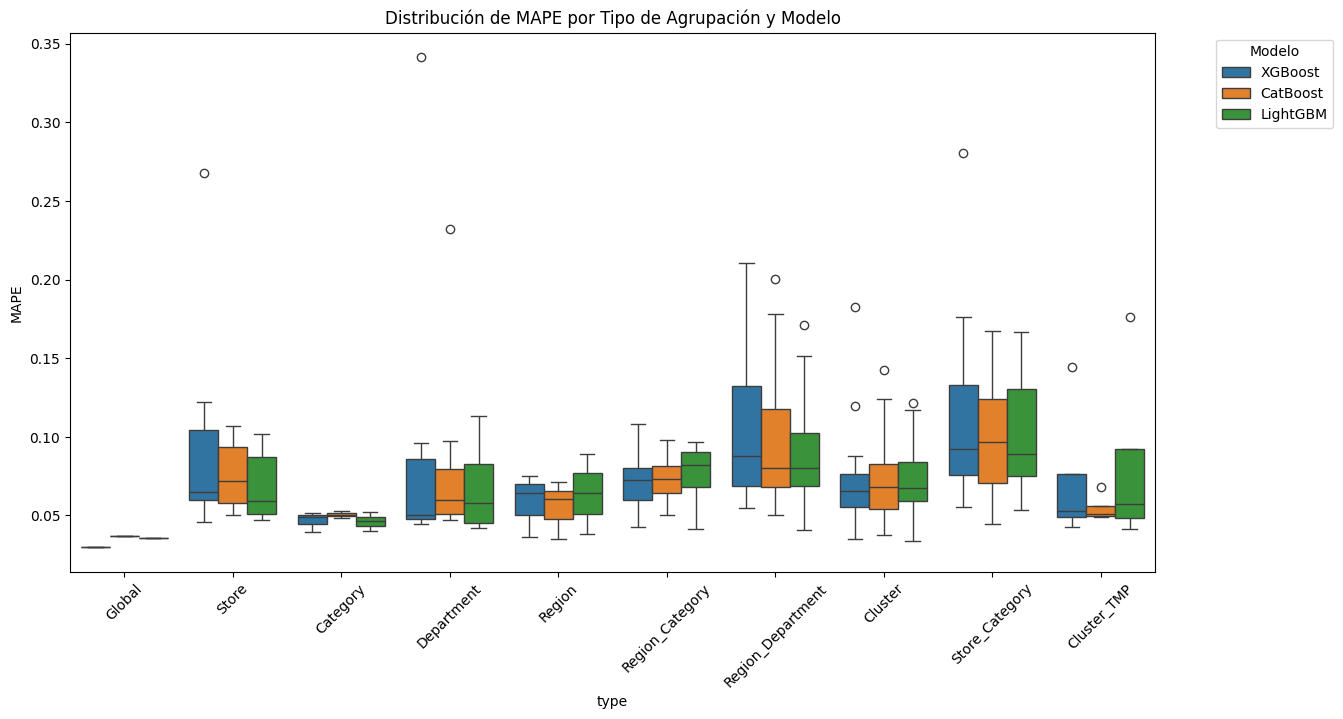

In [5]:
# Visualización de MAPE diferenciado por modelo y tipo de agrupación
plt.figure(figsize=(14, 7))
sns.boxplot(x="type", y="MAPE", hue="model", data=df_metrics_agrupaciones)
plt.title("Distribución de MAPE por Tipo de Agrupación y Modelo")
plt.xticks(rotation=45)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Aquí podemos comparar las diferentes opciones para elegir el mejor modelo. Y podemos ver como seleccionando la opción Cluster obtenemos el mejor MAPE con XGBoost teniendo en cuenta que la agrupación es más especifica y por lo tanto tendremos menos error en la elección de los pesos cuando tengamos que repartir los pesos individuales de los ID.

# <h2 style='background:#4e4e4e; border:0; border-radius: 10px; color:black'><center>2. MODELO DEFINITIVO</center></h2>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>2.1 FUNCION DE MODELO DEFINITIVO</center></h4>

In [7]:
def train_evaluate_models(df, group, type):
    df_prueba = df.groupby('date').agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
}).reset_index().copy()
    df_prueba.loc[df_prueba['daily_sales'] == 0, 'daily_sales'] += 1
    df_prueba.set_index("date", inplace=True)

    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    test_days = 28
    df_prueba.sort_index(inplace=True)
    df_prueba.dropna(inplace=True)
    train_X = df_prueba.iloc[:-test_days][columns_X]
    train_y = df_prueba.iloc[:-test_days][columns_y]
    test_X = df_prueba.iloc[-test_days:][columns_X]
    test_y = df_prueba.iloc[-test_days:][columns_y]

    train_y = train_y.asfreq('D')  # Forzar frecuencia diaria
    test_y = test_y.asfreq('D')  # Aplicar también al conjunto de prueba

    models = {
        'XGBoost': XGBRegressor(random_state=42),
    }
    metrics = {}
    predictions = {}
    predictions_future = {}
    for name, model in models.items():
        validation_size = len(test_y)
        fh = ForecastingHorizon(np.arange(1, 29), is_relative=True)
        forecaster = TransformedTargetForecaster(
            [
                ("deseasonalize_28", Deseasonalizer(model="multiplicative", sp=28)),  # Quita estacionalidad mensual (28 días)
                ("LogTransformer", LogTransformer()),  # Aplica transformación logarítmica
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),  # Elimina tendencia lineal
                ("forecast", make_reduction(model, window_length=28, strategy="recursive", scitype='tabular-regressor')),  # Usa XGBoost con ventana de 28 días
            ]
        )
        # Ajustar Expanding Window Cross-Validation
        cv = SlidingWindowSplitter(
            window_length=28*6,  # 6 meses de historial en cada fold
            fh=fh,  # Predicción de 28 días
            step_length=validation_size  # Se mueve 1 mes en cada iteración
        )
        # 🔹 Ajustar la grilla de hiperparámetros para XGBoost
        if name == "XGBoost":
            param_grid = {
            'forecast__estimator__max_depth': [3, 4, 5],
            'forecast__estimator__learning_rate': [0.05, 0.1],
            'forecast__estimator__n_estimators': [100, 200],
            'forecast__estimator__subsample': [0.7, 0.8, 0.9],
            'forecast__estimator__colsample_bytree': [0.6, 0.8],
            }

        # 🔹 Aplicar búsqueda de hiperparámetros con RandomizedSearchCV
        rscv = ForecastingRandomizedSearchCV(
            forecaster,
            cv=cv,  # Expanding Window CV ajustado a la serie
            param_distributions=param_grid,
            n_iter=10,
            random_state=42,
            error_score='raise',
            n_jobs=-1
        )
        # Entrenar el modelo
        # 🔹 Asegurar que `test_y.index` sea `PeriodIndex` o `DatetimeIndex`
        if isinstance(test_y.index, pd.PeriodIndex):
            ultimo_dia_test = test_y.index[-1].to_timestamp()  # Convertir a Timestamp
        else:
            ultimo_dia_test = test_y.index[-1]  # Ya es un Timestamp

        # 🔹 Generar un rango de fechas para los próximos 28 días con el mismo tipo de índice que `test_y`
        fechas_futuras = pd.date_range(start=ultimo_dia_test + pd.Timedelta(days=1), periods=28, freq="D")

        # 🔹 Asegurar que `fhos` tenga el mismo tipo de índice que el modelo
        if isinstance(test_y.index, pd.PeriodIndex):
            fhos = ForecastingHorizon(pd.PeriodIndex(fechas_futuras, freq="D"), is_relative=False)
        else:
            fhos = ForecastingHorizon(fechas_futuras, is_relative=False)  # Dejar como `DatetimeIndex`

        # 🔹 Entrenar el modelo con los datos hasta `train_y`
        print(f"Entrenando {name}...")
        rscv.fit(X=train_X,y=train_y)
        best_model = rscv.best_forecaster_
        y_pred_transf_cv = rscv.best_forecaster_.predict(fh=fh, X=test_X)
        # 🔹 Predecir los 28 días siguientes al test
        future_X = test_X.copy()
        future_X.index = fechas_futuras  # Establecer las fechas futuras como índice
        future_X["year"] = future_X.index.year
        future_X["month"] = future_X.index.month
        future_X["quarter"] = future_X.index.quarter
        future_X["week"] = future_X.index.isocalendar().week + 1
        future_X["day"] = future_X.index.day
        future_X["weekday_int"] = future_X.index.weekday
        map_dias = {0: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 1, 6: 2}
        future_X["weekday_int"] = future_X["weekday_int"].map(map_dias)
        future_X["holidays_boolean"] = 0  # Asumimos que no hay festivos
        future_X["event_boolean"] = 0  # Asumimos que no hay eventos
        y_pred_transf_oos = rscv.best_forecaster_.predict(fh=fhos, X=future_X)
        metrics[name] = {
            'model': name,
            'MAPE': mean_absolute_percentage_error(test_y, y_pred_transf_cv, symmetric=False),
            'MAE': mean_absolute_error(test_y, y_pred_transf_cv),
            'RMSE': root_mean_squared_error(test_y, y_pred_transf_cv),
            'GROUP' : group,
            'type' : type,
        }
        predictions[name] = y_pred_transf_cv
        predictions_future[name] = y_pred_transf_oos
    df_metrics = pd.DataFrame(metrics).T
    # 🔹 Crear el DataFrame con las fechas de entrenamiento, test y futuro
    df_plot = pd.DataFrame({
        "Fecha": np.concatenate([train_y.index.to_numpy(), test_y.index.to_numpy(), y_pred_transf_oos.index.to_numpy()]),
        "Ventas Reales": np.concatenate([train_y.values.ravel(), test_y.values.ravel(), np.full(len(y_pred_transf_oos), np.nan)])
    })

    # 🔹 Agregar las predicciones de cada modelo en test y futuro
    for name in predictions:
        preds = np.array(predictions[name]).ravel()
        preds_future = np.array(predictions_future[name]).ravel()

        df_plot[f"Predicciones {name}"] = np.concatenate([
            np.full(len(train_y), np.nan),  # Mantener NaN en la parte de entrenamiento
            preds,  # Predicciones en Test
            preds_future  # Predicciones Futuras
        ])

    # 🔹 Crear la figura y agregar las ventas reales
    fig = go.Figure()
    # Agregar la serie de ventas reales
    fig.add_trace(go.Scatter(
        x=df_plot["Fecha"], y=df_plot["Ventas Reales"],
        mode='lines', name="Ventas Reales",
        line=dict(color='black', width=2)
    ))
    # 🔹 Agregar cada modelo con su respectiva predicción
    colors = ['red', 'blue', 'green', 'purple', 'orange']  # Colores para los modelos
    for i, name in enumerate(predictions):
        fig.add_trace(go.Scatter(
            x=df_plot["Fecha"], y=df_plot[f"Predicciones {name}"],
            mode='lines', name=f"Predicciones {name}",
            line=dict(color=colors[i % len(colors)], width=1.5)  # Rotar colores si hay más modelos
        ))

    # 🔹 Configurar diseño del gráfico
    fig.update_layout(
        title=f"Predicción de Ventas con Modelos de Machine Learning en {group}",
        xaxis_title="Fecha",
        yaxis_title="Ventas",
        template="plotly_white",
        legend_title="Tipo de Datos",
    )

    # Mostrar la gráfica interactiva con selección de modelos
    fig.show()

    return df_metrics, best_model, predictions, predictions_future

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>2.2 DESARROLLO DEL MODELO</center></h4>

In [8]:
df_metrics = pd.DataFrame()
models_cluster = {}
list_pred_cluster = {}
list_pred_fut_cluster = {}
for cluster in sorted(df["cluster_base_on_dtw"].unique()):
    print(cluster)
    df_cluster = df[df["cluster_base_on_dtw"] == cluster]
    group = "CLUSTER_" + str(cluster)
    type = "cluster_base_on_dtw"
    df_metrics_cluster, model, list_pred, list_pred_fut = train_evaluate_models(df_cluster, group, type=type)
    models_cluster[group] = model
    list_pred_cluster[group] = list_pred
    list_pred_fut_cluster[group] = list_pred_fut
    df_metrics = pd.concat([df_metrics, df_metrics_cluster], axis = 0)
    df_metrics.to_csv("df_metrics_definitive.csv", index=False)
    with open("models_cluster.pkl", "wb") as f:
        pickle.dump(models_cluster, f)

    with open("list_pred_cluster.pkl", "wb") as f:
        pickle.dump(list_pred_cluster, f)

    with open("list_pred_fut_cluster.pkl", "wb") as f:
        pickle.dump(list_pred_fut_cluster, f)

0.0


c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:90: UserWarning: Parameter n_jobs of ForecastingRandomizedSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Entrenando XGBoost...


1.0


c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:90: UserWarning:

Parameter n_jobs of ForecastingRandomizedSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.



Entrenando XGBoost...


2.0


c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:90: UserWarning:

Parameter n_jobs of ForecastingRandomizedSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.



Entrenando XGBoost...


3.0


c:\Users\Administrador\.conda\envs\Nuclio\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:90: UserWarning:

Parameter n_jobs of ForecastingRandomizedSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.



Entrenando XGBoost...


Con este código estamos guardando los modelos de cada cluster, sus métricas y sus predicciones.

# <h2 style='background:#4e4e4e; border:0; border-radius: 10px; color:black'><center>3. CALCULO DE PESOS</center></h2>

### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>3.1 MÉTODOS DE OBTENCIÓN PESOS</center></h4>

#### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>3.1.1 MACHINE LEARNING</center></h4>

In [ ]:
df_general = df.copy()
df_general['total_sales_cluster'] = df_general.groupby(['cluster', 'date'])['daily_sales'].transform('sum')
df_general['peso_id'] = df_general['daily_sales'] / df_general['total_sales_cluster']

df_general['peso_id'] = df_general['peso_id'].fillna(0)
df_general["cluster"] = df_general["cluster"].astype(int)

# Obtener la fecha más reciente del DataFrame
max_date = df_general['date'].max()
# Calcular la fecha de hace dos años desde la fecha más reciente
two_years_ago = max_date - pd.offsets.DateOffset(years=2)
# Filtrar el DataFrame para incluir solo los últimos dos años
df_general = df_general[df_general['date'] >= two_years_ago]

#VARIABLES DEL MODELO ("FEATURE ENGINEERING")
df_general["mean_month_sales"] = df_general.groupby(["id", "month"])["daily_sales"].transform("mean")
# media de ventas mensuales para ese producto (id)
df_general["mean_month_price"] = df_general.groupby(["id", "month"])["sell_price"].transform("mean")
# Calcular si hay al menos un evento o holiday en el mes
df_general['event_month_boolean'] = df_general.groupby(['year', 'month'])['event_boolean'].transform('max')
df_general['holidays_month_boolean'] = df_general.groupby(['year', 'month'])['holidays_boolean'].transform('max')
daily_events_holidays = df_general.groupby('date').agg({
    'event_boolean': 'max',  # 1 si hay evento ese día, 0 si no
    'holidays_boolean': 'max'  # 1 si hay feriado ese día, 0 si no
}).reset_index()
# Calcular la suma de eventos y feriados por mes y año
monthly_events_holidays = daily_events_holidays.groupby([daily_events_holidays['date'].dt.year,
                                                        daily_events_holidays['date'].dt.month]).agg({
    'event_boolean': 'sum',  # Suma de días con eventos en el mes
    'holidays_boolean': 'sum'  # Suma de días con feriados en el mes
}).rename_axis(['year', 'month']).reset_index()
df_general = df_general.merge(monthly_events_holidays[['year', 'month', 'event_boolean', 'holidays_boolean']],
                        on=['year', 'month'],
                        how='left',
                        suffixes=('', '_in_month'))
# Renombrar las columnas nuevas
df_general = df_general.rename(columns={
    'event_boolean_in_month': 'events_in_month',
    'holidays_boolean_in_month': 'holidays_in_month'
})

In [ ]:
target_col = ["peso_id"]
id_cols = ['id']
numeric_cols = ['year','month','quarter','week','day','sell_price','holidays_boolean','event_boolean','weekday_int','event_month_boolean','holidays_month_boolean','events_in_month','holidays_in_month','mean_month_price']
categoric_cols = ['department','store']
df_pesos = df_general.loc[df["cluster"] == 1, target_col + id_cols + numeric_cols + categoric_cols].copy()
df_pesos = pd.get_dummies(df_pesos, columns= categoric_cols)
X = df_pesos.drop(columns=id_cols + target_col)
y = df_pesos[target_col]
df_ids = df_pesos[id_cols]

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size = .33, random_state = 42)
classifiers = {
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'hiperparameters': {
        'max_depth': randint(2, 6),
        'n_estimators': randint(100, 200),
        'learning_rate': [0.1, 0.05],
        'subsample': uniform(0.6, 0.2)
        }
    }
}
random_search_output = list()
best_estimators = {}
for clf_name, clf_info in classifiers.items():
    print(clf_name)
    clf_random_search = RandomizedSearchCV(
        estimator = clf_info['model'], # Modelo a ajustar
        param_distributions = clf_info['hiperparameters'], # Hiperparámetros a buscar
        n_iter = 10, # Número de combinaciones a probar
        cv = 5, # Validación cruzada con 5 particiones
        scoring = "r2", # Métrica a optimizar
        return_train_score = True, # Incluye las métricas de entrenamiento
        refit = True, # Ajusta el modelo final con los mejores parámetros
        n_jobs = -1, # Usa todos los núcleos disponibles
        verbose = 1 # Nivel de detalle durante el ajuste
    )
    clf_random_search.fit(X_train, y_train)
    # Resultados del Random Search
    df_output = pd.DataFrame(clf_random_search.cv_results_)
    df_output['clf'] = clf_name
    random_search_output.append(df_output)
    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[clf_name] = clf_random_search.best_estimator_
best_model = best_estimators['XGBoost']
y_pred = best_model.predict(X_test)
print('R^2:', r2_score(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred, symmetric=False))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MSE:',mean_squared_error(y_test, y_pred))
print('RMSE:',root_mean_squared_error(y_test, y_pred))
# Importancia de variables
df_importances = pd.DataFrame(data = {
    'variable': X.columns,
    'importance': best_model.feature_importances_
})
df_importances.sort_values('importance', ascending = False, inplace = True)
df_importances.reset_index(drop = True, inplace = True)
n_features = 10
df_importances.iloc[:n_features][::-1].plot(x = 'variable', y = 'importance', kind = 'barh')
plt.show()

#### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>3.1.2 MEDIANTE HISTORICOS DE FORMA MANUAL</center></h4>

In [ ]:
df_cluster_ts = pd.read_pickle('df_cluster_ST.pkl')
list_item_cluster={}
for cluster in df_cluster_ts.cluster_base_on_dtw.unique():
    list_item_cluster[cluster] = df_cluster_ts[df_cluster_ts.cluster_base_on_dtw==cluster].item.to_list()

item_to_cluster = {item: key for key, items in list_item_cluster.items() for item in items}
df['cluster_TS'] = df['item'].map(item_to_cluster)

##### CON TODO EL HISTÓRICO, REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
def prediction_id_daily_TS (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    #Agrupacion item por dia - suma historico
    df_totalsales_item = df.groupby(['item','cluster_TS']).agg({'daily_sales':'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)
    #Agrupacion cluster por dia - suma historico
    df_totalsales_cluster = df .groupby(['cluster_TS']).daily_sales.sum().reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)
    #Agrupacion id por dia - suma historico
    df_totalsales_store = df.groupby(['id','item','cluster_TS']).agg({'daily_sales':'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'},inplace=True)

    #calculamos los pesos
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_S={}
dict_weight_S={}
metric_id_S={}
metric_daily_S={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_S,dict_weight_S, metric_id_S,metric_daily_S = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_S,dict_weight_S, metric_id_S, metric_daily_S)
    display(metric_id_S[key])
    display(metric_daily_S[key])


###############################-------- CLUSTER - 0 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_001_BOS_1,0.000,0.064,0.000,0,1,10.986,South_End,0.000,10.986
1,2016-03-28,ACCESORIES_1_001_BOS_2,0.000,0.098,0.000,0,0,10.986,Roxbury,0.000,0.000
2,2016-03-28,ACCESORIES_1_001_BOS_3,0.000,0.094,0.000,0,0,10.986,Back_Bay,0.000,0.000
3,2016-03-28,ACCESORIES_1_001_NYC_1,0.000,0.147,0.000,0,1,10.986,Greenwich_Village,0.000,10.986
4,2016-03-28,ACCESORIES_1_001_NYC_2,0.000,0.132,0.000,0,0,10.986,Harlem,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
607035,2016-04-24,SUPERMARKET_3_826_NYC_3,0.001,0.102,0.000,1,3,1.536,Tribeca,1.536,4.608
607036,2016-04-24,SUPERMARKET_3_826_NYC_4,0.001,0.151,0.000,1,4,1.536,Brooklyn,1.536,6.144
607037,2016-04-24,SUPERMARKET_3_826_PHI_1,0.001,0.119,0.000,1,2,1.536,Midtown_Village,1.536,3.072
607038,2016-04-24,SUPERMARKET_3_826_PHI_2,0.001,0.094,0.000,0,1,1.536,Yorktown,0.000,1.536


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,166,1008,926.695,6076.882,842.000,-5150.188
1,2016-03-28,Brooklyn,111,820,450.240,4870.672,709.000,-4420.433
2,2016-03-28,Greenwich_Village,416,1153,2070.821,7076.464,737.000,-5005.644
3,2016-03-28,Harlem,341,1229,1831.806,7035.266,888.000,-5203.460
4,2016-03-28,Midtown_Village,227,1078,1042.098,5928.037,851.000,-4885.939
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,365,1088,1645.843,6058.006,723.000,-4412.162
276,2016-04-24,Roxbury,531,1217,2954.362,7831.356,686.000,-4876.995
277,2016-04-24,South_End,277,1058,1543.102,6750.200,781.000,-5207.097
278,2016-04-24,Tribeca,1307,2370,7166.119,14567.983,1063.000,-7401.864


###############################-------- CLUSTER - 1 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_004_BOS_1,0.002,0.075,0.000,1,0,6.171,South_End,6.171,0.000
1,2016-03-28,ACCESORIES_1_004_BOS_2,0.002,0.091,0.000,2,0,6.171,Roxbury,12.342,0.000
2,2016-03-28,ACCESORIES_1_004_BOS_3,0.002,0.081,0.000,1,0,6.171,Back_Bay,6.171,0.000
3,2016-03-28,ACCESORIES_1_004_NYC_1,0.002,0.084,0.000,1,0,6.171,Greenwich_Village,6.171,0.000
4,2016-03-28,ACCESORIES_1_004_NYC_2,0.002,0.192,0.000,4,3,6.171,Harlem,24.685,18.514
...,...,...,...,...,...,...,...,...,...,...,...
190395,2016-04-24,SUPERMARKET_3_827_NYC_3,0.001,0.226,0.000,2,13,1.200,Tribeca,2.400,15.600
190396,2016-04-24,SUPERMARKET_3_827_NYC_4,0.001,0.008,0.000,0,8,1.200,Brooklyn,0.000,9.600
190397,2016-04-24,SUPERMARKET_3_827_PHI_1,0.001,0.240,0.000,2,0,1.200,Midtown_Village,2.400,0.000
190398,2016-04-24,SUPERMARKET_3_827_PHI_2,0.001,0.076,0.000,0,2,1.200,Yorktown,0.000,2.400


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,816,1187,3447.166,5670.487,371.000,-2223.321
1,2016-03-28,Brooklyn,522,982,1732.232,3436.550,460.000,-1704.318
2,2016-03-28,Greenwich_Village,1168,1397,4306.835,5501.154,229.000,-1194.318
3,2016-03-28,Harlem,827,1286,2886.545,4935.369,459.000,-2048.824
4,2016-03-28,Midtown_Village,757,1113,2304.387,4023.178,356.000,-1718.791
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,1347,1516,4799.659,5613.049,169.000,-813.390
276,2016-04-24,Roxbury,1510,1473,5878.662,6684.617,37.000,-805.954
277,2016-04-24,South_End,1141,1315,4256.092,5691.921,174.000,-1435.829
278,2016-04-24,Tribeca,2549,2699,9925.917,12344.738,150.000,-2418.821


###############################-------- CLUSTER - 2 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,SUPERMARKET_1_218_BOS_1,0.031,0.067,0.002,8,9,1.128,South_End,9.024,10.152
1,2016-03-28,SUPERMARKET_1_218_BOS_2,0.031,0.191,0.006,24,4,1.128,Roxbury,27.072,4.512
2,2016-03-28,SUPERMARKET_1_218_BOS_3,0.031,0.095,0.003,12,26,1.128,Back_Bay,13.536,29.328
3,2016-03-28,SUPERMARKET_1_218_NYC_1,0.031,0.095,0.003,12,1,1.176,Greenwich_Village,14.112,1.176
4,2016-03-28,SUPERMARKET_1_218_NYC_2,0.031,0.123,0.004,15,19,1.176,Harlem,17.640,22.344
...,...,...,...,...,...,...,...,...,...,...,...
5875,2016-04-24,SUPERMARKET_3_808_NYC_3,0.038,0.258,0.010,52,0,1.056,Tribeca,54.912,0.000
5876,2016-04-24,SUPERMARKET_3_808_NYC_4,0.038,0.076,0.003,15,0,1.200,Brooklyn,18.000,0.000
5877,2016-04-24,SUPERMARKET_3_808_PHI_1,0.038,0.049,0.002,9,0,1.128,Midtown_Village,10.152,0.000
5878,2016-04-24,SUPERMARKET_3_808_PHI_2,0.038,0.026,0.001,5,0,1.128,Yorktown,5.640,0.000


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,475,384,1035.456,1034.904,91.000,0.552
1,2016-03-28,Brooklyn,177,128,411.216,294.228,49.000,116.988
2,2016-03-28,Greenwich_Village,460,302,1107.996,819.144,158.000,288.852
3,2016-03-28,Harlem,254,293,537.936,683.280,39.000,-145.344
4,2016-03-28,Midtown_Village,212,172,445.464,425.892,40.000,19.572
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,646,606,1399.620,1506.732,40.000,-107.112
276,2016-04-24,Roxbury,739,525,1578.156,1126.680,214.000,451.476
277,2016-04-24,South_End,537,489,1173.636,1113.660,48.000,59.976
278,2016-04-24,Tribeca,934,783,2217.744,2132.904,151.000,84.840


###############################-------- CLUSTER - 3 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_008_BOS_1,0.005,0.065,0.000,2,1,0.638,South_End,1.277,0.638
1,2016-03-28,ACCESORIES_1_008_BOS_2,0.005,0.114,0.001,5,6,0.638,Roxbury,3.192,3.830
2,2016-03-28,ACCESORIES_1_008_BOS_3,0.005,0.056,0.000,2,2,0.638,Back_Bay,1.277,1.277
3,2016-03-28,ACCESORIES_1_008_NYC_1,0.005,0.158,0.001,6,0,0.638,Greenwich_Village,3.830,0.000
4,2016-03-28,ACCESORIES_1_008_NYC_2,0.005,0.090,0.000,3,0,0.638,Harlem,1.915,0.000
...,...,...,...,...,...,...,...,...,...,...,...
50395,2016-04-24,SUPERMARKET_3_816_NYC_3,0.005,0.163,0.001,10,3,0.300,Tribeca,3.000,0.900
50396,2016-04-24,SUPERMARKET_3_816_NYC_4,0.005,0.022,0.000,1,0,0.300,Brooklyn,0.300,0.000
50397,2016-04-24,SUPERMARKET_3_816_PHI_1,0.005,0.044,0.000,2,0,0.300,Midtown_Village,0.600,0.000
50398,2016-04-24,SUPERMARKET_3_816_PHI_2,0.005,0.266,0.001,16,6,0.300,Yorktown,4.800,1.800


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,813,958,1682.394,2202.258,145.000,-519.864
1,2016-03-28,Brooklyn,452,515,887.003,1187.746,63.000,-300.743
2,2016-03-28,Greenwich_Village,1006,1053,2061.595,2357.147,47.000,-295.553
3,2016-03-28,Harlem,624,837,1253.885,1820.063,213.000,-566.178
4,2016-03-28,Midtown_Village,540,676,997.668,1350.458,136.000,-352.790
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,1211,1115,2220.390,2630.475,96.000,-410.084
276,2016-04-24,Roxbury,1290,1077,2585.931,2552.880,213.000,33.051
277,2016-04-24,South_End,994,1171,1981.785,2528.285,177.000,-546.500
278,2016-04-24,Tribeca,2197,1869,4250.051,4303.513,328.000,-53.461


##### CON 1 AÑO DE DATOS,  REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
def prediction_id_daily_TS_365 (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Filtrar datos de los últimos 30 días
    last_365_days = max_date - pd.DateOffset(days=365)
    df_last_365_days = df[df['date'] >= last_365_days]

    # Agrupación item por día - suma últimos 365 días
    df_totalsales_item = df_last_365_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)

    # Agrupación cluster por día - suma últimos 365 días
    df_totalsales_cluster = df_last_365_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)

    # Agrupación id por día - suma últimos 365 días
    df_totalsales_store = df_last_365_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    #calculamos los pesos

    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_W360={}
dict_weight_W360={}
metric_id_W360={}
metric_daily_W360={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_W360,dict_weight_W360, metric_id_W360,metric_daily_W360 = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_W360,dict_weight_W360, metric_id_W360,metric_daily_W360)
    display(metric_id_W360[key])
    display(metric_daily_W360[key])


##### CON 90 DIAS DE DATOS, REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
def prediction_id_daily_TS_90 (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Filtrar datos de los últimos 30 días
    last_90_days = max_date - pd.DateOffset(days=90)
    df_last_90_days = df[df['date'] >= last_90_days]

    # Agrupación item por día - suma últimos 90 días
    df_totalsales_item = df_last_90_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)

    # Agrupación cluster por día - suma últimos 90 días
    df_totalsales_cluster = df_last_90_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)

    # Agrupación id por día - suma últimos 90 días
    df_totalsales_store = df_last_90_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    #calculamos los pesos

    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_W90={}
dict_weight_W90={}
metric_id_W90={}
metric_daily_W90={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_W90,dict_weight_W90, metric_id_W90,metric_daily_W90 = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_W90,dict_weight_W90, metric_id_W90,metric_daily_W90)
    display(metric_id_W90[key])
    display(metric_daily_W90[key])


##### CON 30 DIAS DE DATOS, REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
def prediction_id_daily_TS_30 (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)

    # Agrupación cluster por día - suma últimos 30 días
    df_totalsales_cluster = df_last_30_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)

    # Agrupación id por día - suma últimos 30 días
    df_totalsales_store = df_last_30_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    #calculamos los pesos

    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_W30={}
dict_weight_W30={}
metric_id_W30={}
metric_daily_W30={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_W30,dict_weight_W30, metric_id_W30,metric_daily_W30 = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_W30,dict_weight_W30, metric_id_W30,metric_daily_W30)
    display(metric_id_W30[key])
    display(metric_daily_W30[key])


##### CON 7 DIAS DE DATOS, REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
def prediction_id_daily_TS_7 (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Filtrar datos de los últimos 30 días
    last_7_days = max_date - pd.DateOffset(days=7)
    df_last_7_days = df[df['date'] >= last_7_days]

    # Agrupación item por día - suma últimos 7 días
    df_totalsales_item = df_last_7_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)

    # Agrupación cluster por día - suma últimos 7 días
    df_totalsales_cluster = df_last_7_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)

    # Agrupación id por día - suma últimos 7 días
    df_totalsales_store = df_last_7_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    #calculamos los pesos

    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_W7={}
dict_weight_W7={}
metric_id_W7={}
metric_daily_W7={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_W7,dict_weight_W7, metric_id_W7,metric_daily_W7 = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_W7,dict_weight_W7, metric_id_W7,metric_daily_W7)
    display(metric_id_W7[key])
    display(metric_daily_W7[key])


##### CON  1 AÑO DE DATOS, REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS Y TENIENDO EN CUENTA LA IMPORTANCIA DE LOS DIAS DE VENTA

In [ ]:
def prediction_id_daily_TS_combi(df, df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily, alpha=0.76):

    # Columnas utilizadas en el cálculo
    columns_X = ['year', 'month', 'quarter', 'week', 'day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # Selección del dataset de test para obtener errores
    df_cluster_model = df_filter.groupby(['date']).agg({
        'daily_sales': 'sum',
        'year': 'first',
        'month': 'first',
        'quarter': 'first',
        'week': 'first',
        'day': 'first',
        'weekday_int': 'first',
        'holidays_boolean': 'first',
        'event_boolean': 'first'
    }).reset_index().copy()

    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    # Generar dataset para comparar predicciones del cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame(index=test_X.index, data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns={'daily_sales': 'y_test'}, inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
        y_pred_filter[['daily_sales']], left_index=True, right_index=True, how='left'
    )
    df_compare_pred_cluster.rename(columns={'daily_sales': 'y_pred'}, inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    # Guardar resultados del cluster
    dict_metric_cluster[cluster] = df_compare_pred_cluster

    # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Contar los días de ventas por item
    df_sales_days = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'date': 'nunique'}).reset_index()
    df_sales_days.rename(columns={'date': 'days_sold'}, inplace=True)

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Agrupación de ventas en los últimos 365 días
    last_365_days = max_date - pd.DateOffset(days=365)
    df_last_365_days = df[df['date'] >= last_365_days]
    df_totalsales_item = df_last_365_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)
    df_totalsales_cluster = df_last_365_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)
    df_totalsales_store = df_last_365_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    # Calcular los pesos
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on=['item', 'cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_sales_days, on=['item', 'cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on=['item', 'cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=['cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] = df_totalsales_store['total_sales_item'] / df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] = df_totalsales_store['total_sales'] / df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Calcular el peso ajustado con la proporción alfa
    df_totalsales_store['weight'] = (
        (alpha * df_totalsales_store['weight']) + ((1 - alpha) * (df_totalsales_store['days_sold'] / 30) )
    )

    # Inicializar weight_acum
    weight_acum = 0

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    # Reemplazar NaN e infinitos en weight
    df_totalsales_store['weight'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_totalsales_store['weight'].fillna(0, inplace=True)

    # Normalizar pesos para asegurar valores entre 0 y 1
    max_weight = df_totalsales_store['weight'].max()
    if max_weight > 0:
        df_totalsales_store['weight'] = df_totalsales_store['weight'] / max_weight

    y_pred_filter['date'] = y_pred_filter.index

    # Guardar pesos
    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS'] == cluster.split('_')[1].split('.')[0]][['id', 'weight_cluster', 'weight_item', 'weight']]
    dict_weight[cluster] = df_pesos

    # Añadir pesos al dataframe de predicción
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'], axis=1, inplace=True)
    df_resultado = df_resultado.merge(df_filter[['id', 'date', 'daily_sales', 'sell_price', 'store']], on=['id', 'date'], how='left')
    df_resultado['revenue_pred'] = df_resultado['y_pred'] * df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] * df_resultado['sell_price']

    # Calcular métricas diarias
    df_resultado_diario = df_resultado.groupby(['date', 'store']).agg({
        'y_pred': 'sum',
        'daily_sales': 'sum',
        'revenue_pred': 'sum',
        'revenue': 'sum'
    }).reset_index()
    df_resultado_diario['rmse'] = np.sqrt((df_resultado_diario['daily_sales'] - df_resultado_diario['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario['revenue_pred'] - df_resultado_diario['revenue']

    dict_metric_id[cluster] = df_resultado
    dict_metric_daily[cluster] = df_resultado_diario

    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily



######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_C={}
dict_weight_C={}
metric_id_C={}
metric_daily_C={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_C,dict_weight_C, metric_id_C,metric_daily_C = prediction_id_daily_TS_combi (df, df_filter, y_pred_filter, key, metric_cluster_C,dict_weight_C, metric_id_C,metric_daily_C)
    display(metric_id_C[key])
    display(metric_daily_C[key])


### <h4 style='background:#b4b4b4; border:0; border-radius: 10px; color:black'><center>3.2 MEJOR OPCIÓN</center></h4>

##### CON 30 DIAS REPARTIENDO EL PESO DE AQUELLAS VENTAS QUE HAYAN TENIDO 0 VENTAS EN LOS ÚLTIMOS 30 DIAS

In [ ]:
df_cluster_ts = pd.read_pickle('df_cluster_ST.pkl')
list_item_cluster={}
for cluster in df_cluster_ts.cluster_base_on_dtw.unique():
    list_item_cluster[cluster] = df_cluster_ts[df_cluster_ts.cluster_base_on_dtw==cluster].item.to_list()

item_to_cluster = {item: key for key, items in list_item_cluster.items() for item in items}
df['cluster_TS'] = df['item'].map(item_to_cluster)

In [ ]:
def prediction_id_daily_TS_30 (df,df_filter, y_pred_filter, cluster, dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily):

    #columnas utilizadas en el calculo
    columns_X = ['year', 'month', 'quarter', 'week','day', 'weekday_int', 'holidays_boolean', 'event_boolean']
    columns_y = 'daily_sales'

    # seleccionamos el dataset de test para sacar los errores
    df_cluster_model = df_filter.groupby(['date']).agg({
    'daily_sales': 'sum',
    'year': 'first',
    'month': 'first',
    'quarter': 'first',
    'week': 'first',
    'day': 'first',
    'weekday_int': 'first',
    'holidays_boolean': 'first',
    'event_boolean': 'first'
    }).reset_index().copy()
    test_days = 28
    df_cluster_model.sort_index(inplace=True)
    df_cluster_model.dropna(inplace=True)
    test_X = df_cluster_model.iloc[-test_days:][columns_X]
    test_y = df_cluster_model.iloc[-test_days:][columns_y]

    #generamos dataset para comparar preddiciones cluster
    test_X['date'] = pd.to_datetime(test_X[['year', 'month', 'day']])
    df_compare_pred_cluster = pd.DataFrame( index = test_X.index , data=test_X.date)
    df_compare_pred_cluster = df_compare_pred_cluster.join(test_y)
    df_compare_pred_cluster.rename(columns= {'daily_sales':'y_test'},inplace=True)
    df_compare_pred_cluster = df_compare_pred_cluster.set_index('date')
    df_compare_pred_cluster = df_compare_pred_cluster.merge(
                                        y_pred_filter[['daily_sales']],
                                        left_index=True,
                                        right_index=True,
                                        how='left'
                                        )
    df_compare_pred_cluster.rename(columns={'daily_sales':'y_pred'},inplace=True)
    df_compare_pred_cluster['rmse_cluster'] = np.sqrt((df_compare_pred_cluster['y_test'] - df_compare_pred_cluster['y_pred']) ** 2)

    #guardamos resultados cluster
    dict_metric_cluster [cluster] = df_compare_pred_cluster

        # Determinar la fecha máxima disponible
    max_date = df['date'].max()

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales30_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales30_item.rename(columns={'daily_sales': 'total_sales_last30'}, inplace=True)

    # Filtrar datos de los últimos 30 días
    last_30_days = max_date - pd.DateOffset(days=30)
    df_last_30_days = df[df['date'] >= last_30_days]

    # Agrupación item por día - suma últimos 30 días
    df_totalsales_item = df_last_30_days.groupby(['item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_item.rename(columns={'daily_sales': 'total_sales_item'}, inplace=True)

    # Agrupación cluster por día - suma últimos 30 días
    df_totalsales_cluster = df_last_30_days.groupby(['cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_cluster.rename(columns={'daily_sales': 'total_sales_cluster'}, inplace=True)

    # Agrupación id por día - suma últimos 30 días
    df_totalsales_store = df_last_30_days.groupby(['id', 'item', 'cluster_TS']).agg({'daily_sales': 'sum'}).reset_index()
    df_totalsales_store.rename(columns={'daily_sales': 'total_sales'}, inplace=True)

    #calculamos los pesos

    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales30_item, on= ['item','cluster_TS'], how='left')
    df_totalsales_store = pd.merge(df_totalsales_store, df_totalsales_cluster, on=[ 'cluster_TS'], how='left')
    df_totalsales_store['weight_cluster'] =  df_totalsales_store['total_sales_item']/df_totalsales_store['total_sales_cluster']
    df_totalsales_store['weight_item'] =  df_totalsales_store['total_sales']/df_totalsales_store['total_sales_item']
    df_totalsales_store['weight'] = df_totalsales_store['weight_item'] * df_totalsales_store['weight_cluster']

    # Acumular el peso de las filas con total_sales == 0
    weight_acum = df_totalsales_store.loc[df_totalsales_store['total_sales_last30'] == 0, 'weight'].sum()

    # Calcular peso y acumular si las ventas son 0
    df_totalsales_store['weight'] = df_totalsales_store.apply(
        lambda row: row['weight'] if row['total_sales_last30'] > 0 else 0, axis=1
    )

    print(f"########## Peso acumulado de ventas nulas en los últimos 30 días {weight_acum} #############")

    # Redistribuir el peso acumulado entre las filas con total_sales > 0
    mask = df_totalsales_store['total_sales_last30'] > 0
    total_weight = df_totalsales_store.loc[mask, 'weight'].sum()

    if weight_acum > 0:
        df_totalsales_store.loc[mask, 'weight'] += (df_totalsales_store.loc[mask, 'weight'] / total_weight) * weight_acum

    y_pred_filter['date'] = y_pred_filter.index

    df_pesos = df_totalsales_store[df_totalsales_store['cluster_TS']==cluster.split("_")[1].split(".")[0]][['id','weight_cluster','weight_item','weight']]
    dict_weight[cluster] = df_pesos

    #añades los pesos al df de prediccion
    df_resultado = y_pred_filter.merge(df_pesos, how='cross')
    #Calcular la cantidad esperada de ventas por día e ítem
    df_resultado['y_pred'] = (df_resultado['daily_sales'] * df_resultado['weight']).astype(int)
    df_resultado.drop(columns=['daily_sales'],axis=1,inplace=True)
    #unir campo de precios, comprar diarias, tienda del df original
    df_resultado= df_resultado.merge( df_filter[['id', 'date','daily_sales','sell_price','store']], on=['id','date'] ,how='left')
    #calculo error coste
    df_resultado['revenue_pred'] = df_resultado['y_pred'] *  df_resultado['sell_price']
    df_resultado['revenue'] = df_resultado['daily_sales'] *  df_resultado['sell_price']
    df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',
                                    'daily_sales':'sum',
                                    'revenue_pred':'sum',
                                    'revenue':'sum'}).reset_index()
    df_resultado_diario['rsme'] = np.sqrt((df_resultado_diario ['daily_sales'] - df_resultado_diario ['y_pred']) ** 2)
    df_resultado_diario['error_coste'] = df_resultado_diario ['revenue_pred'] - df_resultado_diario ['revenue']

    dict_metric_id [cluster] = df_resultado
    dict_metric_daily [cluster] = df_resultado_diario


    return dict_metric_cluster, dict_weight, dict_metric_id, dict_metric_daily


######################################
dict_y_pred = pd.read_pickle('list_pred_cluster_2.pkl')

metric_cluster_W30={}
dict_weight_W30={}
metric_id_W30={}
metric_daily_W30={}

for key,value in dict_y_pred.items():
    cluster = key.split("_")[1].split(".")[0]
    print('###############################-------- CLUSTER - '+ str(cluster) + ' ------------#################################################')
    df_filter = df.query(f'cluster_TS == "{cluster}"')
    y_pred_filter = pd.DataFrame(dict_y_pred[key]['XGBoost'])
    metric_cluster_W30,dict_weight_W30, metric_id_W30,metric_daily_W30 = prediction_id_daily_TS (df, df_filter, y_pred_filter, key, metric_cluster_W30,dict_weight_W30, metric_id_W30,metric_daily_W30)
    display(metric_id_W30[key])
    display(metric_daily_W30[key])


###############################-------- CLUSTER - 0 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',


,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_001_BOS_1,0.000,0.064,0.000,0,1,10.986,South_End,0.000,10.986
1,2016-03-28,ACCESORIES_1_001_BOS_2,0.000,0.098,0.000,0,0,10.986,Roxbury,0.000,0.000
2,2016-03-28,ACCESORIES_1_001_BOS_3,0.000,0.094,0.000,0,0,10.986,Back_Bay,0.000,0.000
3,2016-03-28,ACCESORIES_1_001_NYC_1,0.000,0.147,0.000,0,1,10.986,Greenwich_Village,0.000,10.986
4,2016-03-28,ACCESORIES_1_001_NYC_2,0.000,0.132,0.000,0,0,10.986,Harlem,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
607035,2016-04-24,SUPERMARKET_3_826_NYC_3,0.001,0.102,0.000,1,3,1.536,Tribeca,1.536,4.608
607036,2016-04-24,SUPERMARKET_3_826_NYC_4,0.001,0.151,0.000,1,4,1.536,Brooklyn,1.536,6.144
607037,2016-04-24,SUPERMARKET_3_826_PHI_1,0.001,0.119,0.000,1,2,1.536,Midtown_Village,1.536,3.072
607038,2016-04-24,SUPERMARKET_3_826_PHI_2,0.001,0.094,0.000,0,1,1.536,Yorktown,0.000,1.536


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,166,1008,926.695,6076.882,842.000,-5150.188
1,2016-03-28,Brooklyn,111,820,450.240,4870.672,709.000,-4420.433
2,2016-03-28,Greenwich_Village,416,1153,2070.821,7076.464,737.000,-5005.644
3,2016-03-28,Harlem,341,1229,1831.806,7035.266,888.000,-5203.460
4,2016-03-28,Midtown_Village,227,1078,1042.098,5928.037,851.000,-4885.939
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,365,1088,1645.843,6058.006,723.000,-4412.162
276,2016-04-24,Roxbury,531,1217,2954.362,7831.356,686.000,-4876.995
277,2016-04-24,South_End,277,1058,1543.102,6750.200,781.000,-5207.097
278,2016-04-24,Tribeca,1307,2370,7166.119,14567.983,1063.000,-7401.864


###############################-------- CLUSTER - 1 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',


,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_004_BOS_1,0.002,0.075,0.000,1,0,6.171,South_End,6.171,0.000
1,2016-03-28,ACCESORIES_1_004_BOS_2,0.002,0.091,0.000,2,0,6.171,Roxbury,12.342,0.000
2,2016-03-28,ACCESORIES_1_004_BOS_3,0.002,0.081,0.000,1,0,6.171,Back_Bay,6.171,0.000
3,2016-03-28,ACCESORIES_1_004_NYC_1,0.002,0.084,0.000,1,0,6.171,Greenwich_Village,6.171,0.000
4,2016-03-28,ACCESORIES_1_004_NYC_2,0.002,0.192,0.000,4,3,6.171,Harlem,24.685,18.514
...,...,...,...,...,...,...,...,...,...,...,...
190395,2016-04-24,SUPERMARKET_3_827_NYC_3,0.001,0.226,0.000,2,13,1.200,Tribeca,2.400,15.600
190396,2016-04-24,SUPERMARKET_3_827_NYC_4,0.001,0.008,0.000,0,8,1.200,Brooklyn,0.000,9.600
190397,2016-04-24,SUPERMARKET_3_827_PHI_1,0.001,0.240,0.000,2,0,1.200,Midtown_Village,2.400,0.000
190398,2016-04-24,SUPERMARKET_3_827_PHI_2,0.001,0.076,0.000,0,2,1.200,Yorktown,0.000,2.400


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,816,1187,3447.166,5670.487,371.000,-2223.321
1,2016-03-28,Brooklyn,522,982,1732.232,3436.550,460.000,-1704.318
2,2016-03-28,Greenwich_Village,1168,1397,4306.835,5501.154,229.000,-1194.318
3,2016-03-28,Harlem,827,1286,2886.545,4935.369,459.000,-2048.824
4,2016-03-28,Midtown_Village,757,1113,2304.387,4023.178,356.000,-1718.791
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,1347,1516,4799.659,5613.049,169.000,-813.390
276,2016-04-24,Roxbury,1510,1473,5878.662,6684.617,37.000,-805.954
277,2016-04-24,South_End,1141,1315,4256.092,5691.921,174.000,-1435.829
278,2016-04-24,Tribeca,2549,2699,9925.917,12344.738,150.000,-2418.821


###############################-------- CLUSTER - 2 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',


,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,SUPERMARKET_1_218_BOS_1,0.031,0.067,0.002,8,9,1.128,South_End,9.024,10.152
1,2016-03-28,SUPERMARKET_1_218_BOS_2,0.031,0.191,0.006,24,4,1.128,Roxbury,27.072,4.512
2,2016-03-28,SUPERMARKET_1_218_BOS_3,0.031,0.095,0.003,12,26,1.128,Back_Bay,13.536,29.328
3,2016-03-28,SUPERMARKET_1_218_NYC_1,0.031,0.095,0.003,12,1,1.176,Greenwich_Village,14.112,1.176
4,2016-03-28,SUPERMARKET_1_218_NYC_2,0.031,0.123,0.004,15,19,1.176,Harlem,17.640,22.344
...,...,...,...,...,...,...,...,...,...,...,...
5875,2016-04-24,SUPERMARKET_3_808_NYC_3,0.038,0.258,0.010,52,0,1.056,Tribeca,54.912,0.000
5876,2016-04-24,SUPERMARKET_3_808_NYC_4,0.038,0.076,0.003,15,0,1.200,Brooklyn,18.000,0.000
5877,2016-04-24,SUPERMARKET_3_808_PHI_1,0.038,0.049,0.002,9,0,1.128,Midtown_Village,10.152,0.000
5878,2016-04-24,SUPERMARKET_3_808_PHI_2,0.038,0.026,0.001,5,0,1.128,Yorktown,5.640,0.000


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,475,384,1035.456,1034.904,91.000,0.552
1,2016-03-28,Brooklyn,177,128,411.216,294.228,49.000,116.988
2,2016-03-28,Greenwich_Village,460,302,1107.996,819.144,158.000,288.852
3,2016-03-28,Harlem,254,293,537.936,683.280,39.000,-145.344
4,2016-03-28,Midtown_Village,212,172,445.464,425.892,40.000,19.572
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,646,606,1399.620,1506.732,40.000,-107.112
276,2016-04-24,Roxbury,739,525,1578.156,1126.680,214.000,451.476
277,2016-04-24,South_End,537,489,1173.636,1113.660,48.000,59.976
278,2016-04-24,Tribeca,934,783,2217.744,2132.904,151.000,84.840


###############################-------- CLUSTER - 3 ------------#################################################
########## Peso acumulado de ventas nulas en los últimos 30 días 0.03595635450131729 #############


C:\Users\crist\AppData\Local\Temp\ipykernel_32304\1148388805.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resultado_diario  = df_resultado.groupby(['date','store']).agg({'y_pred':'sum',


,date,id,weight_cluster,weight_item,weight,y_pred,daily_sales,sell_price,store,revenue_pred,revenue
0,2016-03-28,ACCESORIES_1_008_BOS_1,0.005,0.065,0.000,2,1,0.638,South_End,1.277,0.638
1,2016-03-28,ACCESORIES_1_008_BOS_2,0.005,0.114,0.001,5,6,0.638,Roxbury,3.192,3.830
2,2016-03-28,ACCESORIES_1_008_BOS_3,0.005,0.056,0.000,2,2,0.638,Back_Bay,1.277,1.277
3,2016-03-28,ACCESORIES_1_008_NYC_1,0.005,0.158,0.001,6,0,0.638,Greenwich_Village,3.830,0.000
4,2016-03-28,ACCESORIES_1_008_NYC_2,0.005,0.090,0.000,3,0,0.638,Harlem,1.915,0.000
...,...,...,...,...,...,...,...,...,...,...,...
50395,2016-04-24,SUPERMARKET_3_816_NYC_3,0.005,0.163,0.001,10,3,0.300,Tribeca,3.000,0.900
50396,2016-04-24,SUPERMARKET_3_816_NYC_4,0.005,0.022,0.000,1,0,0.300,Brooklyn,0.300,0.000
50397,2016-04-24,SUPERMARKET_3_816_PHI_1,0.005,0.044,0.000,2,0,0.300,Midtown_Village,0.600,0.000
50398,2016-04-24,SUPERMARKET_3_816_PHI_2,0.005,0.266,0.001,16,6,0.300,Yorktown,4.800,1.800


,date,store,y_pred,daily_sales,revenue_pred,revenue,rsme,error_coste
0,2016-03-28,Back_Bay,813,958,1682.394,2202.258,145.000,-519.864
1,2016-03-28,Brooklyn,452,515,887.003,1187.746,63.000,-300.743
2,2016-03-28,Greenwich_Village,1006,1053,2061.595,2357.147,47.000,-295.553
3,2016-03-28,Harlem,624,837,1253.885,1820.063,213.000,-566.178
4,2016-03-28,Midtown_Village,540,676,997.668,1350.458,136.000,-352.790
...,...,...,...,...,...,...,...,...
275,2016-04-24,Queen_Village,1211,1115,2220.390,2630.475,96.000,-410.084
276,2016-04-24,Roxbury,1290,1077,2585.931,2552.880,213.000,33.051
277,2016-04-24,South_End,994,1171,1981.785,2528.285,177.000,-546.500
278,2016-04-24,Tribeca,2197,1869,4250.051,4303.513,328.000,-53.461
